# Análisis Exploratorio Integral - Índice Delictivo en Hermosillo

## Descripción General

Este notebook realiza un **análisis exploratorio completo** del dataset unificado de incidentes delictivos en Hermosillo. Se incluyen múltiples técnicas de análisis estadístico y visualización para extraer insights relevantes.

### Secciones Principales:

| Sección | Objetivo |
|---------|----------|
| Carga de Datos | Importar librerías y cargar dataset unificado |
| Datos Faltantes | Análisis de completitud y valores nulos |
| Hallazgos Procesados | Patrones temporales y geográficos clave |
| Detección de Anomalías | Métodos estadísticos (Z-Score, IQR) |
| Análisis PCA | Reducción dimensional y varianza explicada |
| Conclusiones | Resumen ejecutivo y recomendaciones |

---

## 1. Configuración Inicial: importar Librerías y cargar datos

Esta sección configura el entorno de análisis, suprime advertencias innecesarias y carga los datos del dataset unificado.## 1. Importar Librerías y Cargar Datos

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify # Biblioteca para crear treemaps
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
import os
import missingno as msno # Librería para visualización de datos faltantes
import ast
import math

# Suprimir todos los warnings
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

# Suprimir warnings específicos de librerías
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('seaborn').setLevel(logging.ERROR)
logging.getLogger('sklearn').setLevel(logging.ERROR)

# ===== CONFIGURACIÓN DE ESTILOS PROFESIONALES =====
# Paletas de colores
sns.set_palette("husl")
sns.set_theme(style="whitegrid")

# Tema personalizado
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.1)

# Cargar datos
project_root = Path.cwd().parent
data_path = project_root / 'data' / 'processed' / 'unificado' / 'poligonos_unificados_completo.csv'

print(f"Cargando datos desde: {data_path}")
df = pd.read_csv(data_path)

print(f"\n✓ Dataset cargado exitosamente")
print(f"  Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
df.head()

Cargando datos desde: c:\Users\fanny\OneDrive\Documentos\_MCD\ing_caracteristicas\proyectos\delitos_hmo\indice-delictivo-hermosillo\data\processed\unificado\poligonos_unificados_completo.csv

✓ Dataset cargado exitosamente
  Dimensiones: 700 filas × 30 columnas

Primeras filas:


,cve_ent,cve_mun,cve_loc,nom_loc,CVE_COL,COLONIA,CP,otros_cp,total_incidentes,incidentes_alta,...,viviendas_totales,escolaridad_años_prom,pctj_menores18,pctj_hombres,pctj_mujeres,tasa_incidentes_per_1k,tasa_alta_severidad_per_1k,score_severidad,area_km2,densidad_poblacional
0,26,30,1,Hermosillo,2603000016735,ALTA FIRENZE NORTE RESIDENCIAL,83104.0,NaN,1,1,...,68.0,14.9,28.6%,49.4%,50.6%,12.987013,12.987013,3.000000,0.037555,2050.340413
1,26,30,1,Hermosillo,2603000011785,JORGE VALDEZ MUÃOZ,83104.0,NaN,3066,1404,...,366.0,9.4,35.7%,49.9%,50.1%,2836.262720,1298.797410,2.199609,0.108585,9955.346547
2,26,30,1,Hermosillo,2603000016335,VILLA VERDE CERRADA SAN VICENTE,83118.0,NaN,0,0,...,261.0,9.5,40.4%,52.4%,47.6%,0.000000,0.000000,0.000000,0.060584,11801.826946
3,26,30,1,Hermosillo,2603000011480,VILLA VENTURA,83159.0,NaN,0,0,...,86.0,14.2,21.7%,46.5%,53.5%,0.000000,0.000000,0.000000,0.017695,6781.506720
4,26,30,1,Hermosillo,2603000011663,NUEVO HERMOSILLO,83296.0,NaN,43761,15415,...,4102.0,10.7,29.4%,49.1%,50.9%,3465.119962,1220.603373,2.022691,1.266794,9969.263119


In [67]:
# Función para explotar columnas de diccionarios
def explotar_columna_dict(df_original, nombre_columna, prefijo_col_nueva):
    """
    Expande una columna de un DataFrame que contiene diccionarios
    en múltiples columnas nuevas y las une al DataFrame original.

    Args:
        df_original (pd.DataFrame): El DataFrame original.
        nombre_columna (str): El nombre de la columna que contiene los diccionarios.
        prefijo_col_nueva (str): Un prefijo para las nuevas columnas (ej. 'dia_').

    Returns:
        pd.DataFrame: El DataFrame con las columnas explotadas.
    """
    print(f"Procesando columna: {nombre_columna}...")
    
    # Copia para evitar advertencias de SettingWithCopyWarning
    df = df_original.copy()

    # --- PASO 1: Asegurarse de que son diccionarios (y no strings) ---
    # Tomar la primera fila no nula para chequear el tipo
    filas_no_nulas = df[nombre_columna].dropna()
    
    if filas_no_nulas.empty:
        print(f"  -> Columna '{nombre_columna}' está vacía. Omitiendo.")
        return df_original # Devolver el df sin cambios

    if isinstance(filas_no_nulas.iloc[0], str):
        print(f"  -> Detectado string. Convirtiendo '{nombre_columna}' usando ast.literal_eval...")
        # Llenar NaNs temporalmente con un string de dict vacío
        # y luego aplicar ast.literal_eval de forma segura
        df[nombre_columna] = df[nombre_columna].fillna('{}').apply(ast.literal_eval)
    else:
         print(f"  -> El tipo de dato es {type(filas_no_nulas.iloc[0])}. Asumiendo que es dict.")
         # Rellenar NaNs (nulos) con diccionarios vacíos para evitar errores
         df[nombre_columna] = df[nombre_columna].apply(lambda x: {} if pd.isna(x) else x)

    # --- PASO 2: Explotar el diccionario a un nuevo DataFrame ---
    # Convertimos la Serie de diccionarios en un DataFrame.
    # El índice se alinea automáticamente con el 'df' original.
    df_explotado = pd.DataFrame(df[nombre_columna].tolist(), index=df.index)

    # --- PASO 3: Limpiar y prefijar ---
    # Rellenar cualquier NaN (keys que no estaban en un dict) con 0
    df_explotado = df_explotado.fillna(0).astype(int)

    # Añadir un prefijo para evitar colisiones de nombres (ej. 'cat_robo')
    df_explotado = df_explotado.add_prefix(prefijo_col_nueva)
    
    print(f"  -> Columnas creadas: {list(df_explotado.columns)}")

    # --- PASO 4: Unir y limpiar ---
    # Unir el df original (sin la columna de dict) con el nuevo df explotado
    df_final = pd.concat([df.drop(nombre_columna, axis=1), df_explotado], axis=1)

    return df_final

### 1.1 Información General del Dataset

Examen preliminar de la estructura, tipos de datos y estadísticas descriptivas.

In [68]:
# Lista de columnas a explotar y los prefijos que queremos
columnas_a_explotar = {
    'dias_semana_dict': 'dia_',
    'partes_dia_dict': 'partedia_',
    'categorias_dict': 'cat_'
}

# Copiamos el df para mantener el original intacto
df_limpio = df.copy()

# Iteramos y aplicamos la función para cada columna
for columna, prefijo in columnas_a_explotar.items():
    if columna in df_limpio.columns:
        df_limpio = explotar_columna_dict(df_limpio, columna, prefijo)
    else:
        print(f"ADVERTENCIA: La columna '{columna}' no se encontró en el DataFrame. Se omitirá.")


print("\n--- ¡Proceso completado! ---")
print("DataFrame final con todas las columnas explotadas:")


Procesando columna: dias_semana_dict...
  -> Detectado string. Convirtiendo 'dias_semana_dict' usando ast.literal_eval...
  -> Columnas creadas: ['dia_Martes', 'dia_Domingo', 'dia_Sábado', 'dia_Lunes', 'dia_Viernes', 'dia_Miércoles', 'dia_Jueves']
Procesando columna: partes_dia_dict...
  -> Detectado string. Convirtiendo 'partes_dia_dict' usando ast.literal_eval...
  -> Columnas creadas: ['partedia_Tarde', 'partedia_Noche', 'partedia_Madrugada', 'partedia_Mañana']
Procesando columna: categorias_dict...
  -> Detectado string. Convirtiendo 'categorias_dict' usando ast.literal_eval...
  -> Columnas creadas: ['cat_DELITO PATRIMONIAL', 'cat_CONVIVENCIA', 'cat_VIOLENCIA', 'cat_EMERGENCIAS MÉDICAS', 'cat_INCENDIOS Y EXPLOSIONES', 'cat_RESCATE', 'cat_TRÁNSITO', 'cat_INFRAESTRUCTURA', 'cat_OTROS ACTOS LEGALES', 'cat_DELITO CONTRA SALUD', 'cat_DESASTRES NATURALES', 'cat_ELECTORAL']

--- ¡Proceso completado! ---
DataFrame final con todas las columnas explotadas:


In [69]:
df_limpio['incidentes_fin_semana'] = df_limpio['dia_Sábado'] + df_limpio['dia_Domingo']

In [70]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cve_ent                      700 non-null    int64  
 1   cve_mun                      700 non-null    int64  
 2   cve_loc                      700 non-null    int64  
 3   nom_loc                      700 non-null    object 
 4   CVE_COL                      700 non-null    int64  
 5   COLONIA                      700 non-null    object 
 6   CP                           700 non-null    float64
 7   otros_cp                     0 non-null      float64
 8   total_incidentes             700 non-null    int64  
 9   incidentes_alta              700 non-null    int64  
 10  incidentes_media             700 non-null    int64  
 11  incidentes_baja              700 non-null    int64  
 12  incidentes_fin_semana        700 non-null    int64  
 13  incidentes_quincena 

In [71]:
#Definición de tipos de datos para cada columna
col_categoricas = ['CVE_COL', 'COLONIA','CP']
df_limpio[col_categoricas] = df_limpio[col_categoricas].astype('category')

col_numericas = ['pctj_menores18', 'pctj_hombres', 'pctj_mujeres']
for columna in col_numericas:
    df_limpio[columna] = df_limpio[columna].str[:-1]
df_limpio[col_numericas] = df_limpio[col_numericas].astype('float')

#Eliminación de columnas redundantes/irrelevantes
columnas_a_eliminar = ['cve_ent',
                       'cve_mun',
                       'otros_cp', 
                       'cve_loc',
                       'nom_loc',
                       'incidentes_quincena'
                       ]
df_limpio = df_limpio.drop(columns=columnas_a_eliminar, axis = 1)

In [9]:
# Información general
print("="*70)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*70)
print(f"\nTipo de datos:\n")
print(df_limpio.dtypes)
print(f"\nEstadísticas descriptivas:\n")
df_limpio.describe().T

INFORMACIÓN GENERAL DEL DATASET

Tipo de datos:

CVE_COL                        category
COLONIA                        category
CP                             category
total_incidentes                  int64
incidentes_alta                   int64
incidentes_media                  int64
incidentes_baja                   int64
incidentes_fin_semana             int64
fecha_inicio                     object
fecha_fin                        object
poblacion_total                 float64
viviendas_totales               float64
escolaridad_años_prom           float64
pctj_menores18                  float64
pctj_hombres                    float64
pctj_mujeres                    float64
tasa_incidentes_per_1k          float64
tasa_alta_severidad_per_1k      float64
score_severidad                 float64
area_km2                        float64
densidad_poblacional            float64
dia_Martes                        int64
dia_Domingo                       int64
dia_Sábado                     

,count,mean,std,min,25%,50%,75%,max
total_incidentes,700.0,3109.645714,8735.781961,0.000000,0.750000,430.500000,2675.000000,1.579690e+05
incidentes_alta,700.0,1087.212857,2872.708030,0.000000,0.000000,134.000000,865.000000,4.626100e+04
incidentes_media,700.0,1256.200000,3780.424365,0.000000,0.000000,163.500000,1109.750000,7.078400e+04
incidentes_baja,700.0,766.232857,2183.428513,0.000000,0.000000,98.000000,691.250000,4.092400e+04
incidentes_fin_semana,700.0,1070.522857,2866.787739,0.000000,0.000000,137.500000,915.250000,4.913400e+04
poblacion_total,659.0,1290.000000,2095.321602,0.000000,260.500000,618.000000,1390.500000,2.039800e+04
viviendas_totales,659.0,445.330804,715.978916,0.000000,92.500000,216.000000,491.000000,7.175000e+03
escolaridad_años_prom,642.0,12.433022,2.250755,1.700000,10.500000,12.700000,14.500000,1.870000e+01
pctj_menores18,642.0,28.658879,9.560639,4.700000,21.725000,29.450000,35.075000,9.970000e+01
pctj_hombres,642.0,49.308879,4.133158,27.000000,47.800000,49.200000,50.400000,1.000000e+02


---

Evaluación exhaustiva de valores faltantes, patrones de ausencia y evaluación de calidad de datos.

## 2. Análisis de Integridad de Datos

In [19]:
# Análisis de datos faltantes
print("="*70)
print("ANÁLISIS DE DATOS FALTANTES")
print("="*70)

# Contar valores nulos
missing_data = pd.DataFrame({
    'Columna': df_limpio.columns,
    'Valores_Nulos': df_limpio.isnull().sum(),
    'Porcentaje': (df_limpio.isnull().sum() / len(df) * 100).round(2),
    'Tipo_Datos': df_limpio.dtypes
}).sort_values('Valores_Nulos', ascending=False)

missing_data = missing_data[missing_data['Valores_Nulos'] > 0]

if len(missing_data) == 0:
    print("\n* No hay datos faltantes en el dataset")
else:
    print(f"\n Se encontraron {len(missing_data)} columnas con datos faltantes:\n")
    print(missing_data.to_string())

print(f"\nTotal de valores nulos: {df_limpio.isnull().sum().sum():,}")
print(f"Porcentaje total de valores nulos: {(df_limpio.isnull().sum().sum() / (df_limpio.shape[0] * df_limpio.shape[1]) * 100):.2f}%")

ANÁLISIS DE DATOS FALTANTES

 Se encontraron 11 columnas con datos faltantes:

                                               Columna  Valores_Nulos  Porcentaje Tipo_Datos
fecha_inicio                              fecha_inicio            175       25.00     object
fecha_fin                                    fecha_fin            175       25.00     object
pctj_menores18                          pctj_menores18             58        8.29    float64
escolaridad_años_prom            escolaridad_años_prom             58        8.29    float64
pctj_mujeres                              pctj_mujeres             58        8.29    float64
pctj_hombres                              pctj_hombres             58        8.29    float64
tasa_alta_severidad_per_1k  tasa_alta_severidad_per_1k             55        7.86    float64
tasa_incidentes_per_1k          tasa_incidentes_per_1k             55        7.86    float64
densidad_poblacional              densidad_poblacional             55        7.86   

### 2.1 Visualización de Valores Faltantes

Representación gráfica del volumen y distribución de datos incompletos por columna.

<Axes: >

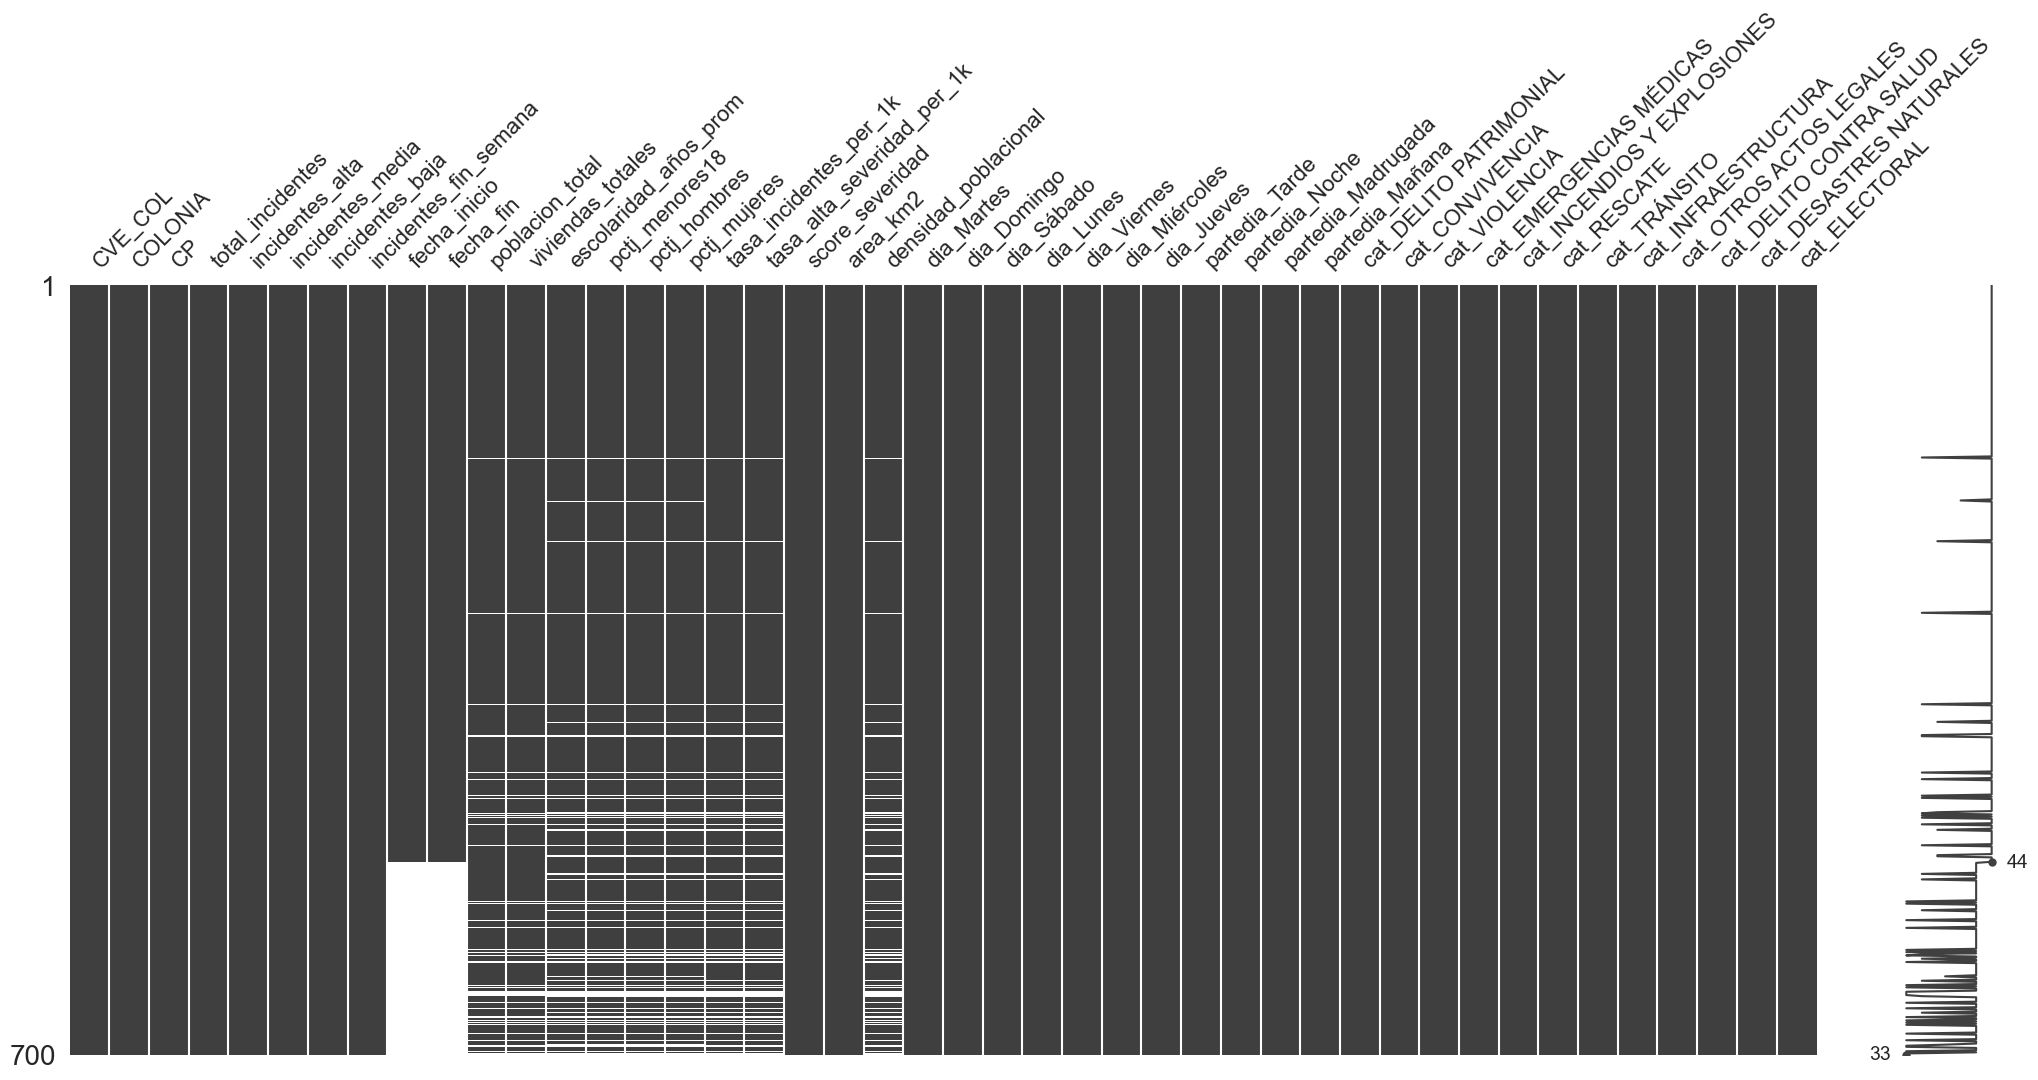

In [20]:
#Matriz de datos faltantes ordenada por fecha_inicio de los reportes
sorted = df_limpio.sort_values('fecha_inicio')
msno.matrix(sorted)

In [21]:
#Cruce de colonias sin incidentes y su población
df_limpio[df_limpio['fecha_inicio'].isnull()][['COLONIA', 'poblacion_total', 'total_incidentes']]

,COLONIA,poblacion_total,total_incidentes
2,VILLA VERDE CERRADA SAN VICENTE,715.0,0
3,VILLA VENTURA,120.0,0
7,COLINA BLANCA,296.0,0
11,EL 33,179.0,0
15,LA JOLLA SECCION VILLA DE LOS DIAMANTES,23.0,0
...,...,...,...
674,LOMAS DEL MARQUEZ,656.0,0
687,LAS VEREDAS,NaN,0
688,AMPLIACIN 4 DE MARZO,781.0,0
690,PRIVADA LOS SAUCES,NaN,0


Podemos observar que los valores faltantes de las siguientes columnas coinciden: 
* **fecha_inicio**
* **fecha_fin**
 
 
 es posible que las observaciones/colonias que tienen valores faltantes en estas columnas no se encuentren en el registro de llamadas recibidas del 911 o que haya habido un error a la hora de unir las bases de datos de demografía y reportes de llamadas recibidas.

<Axes: >

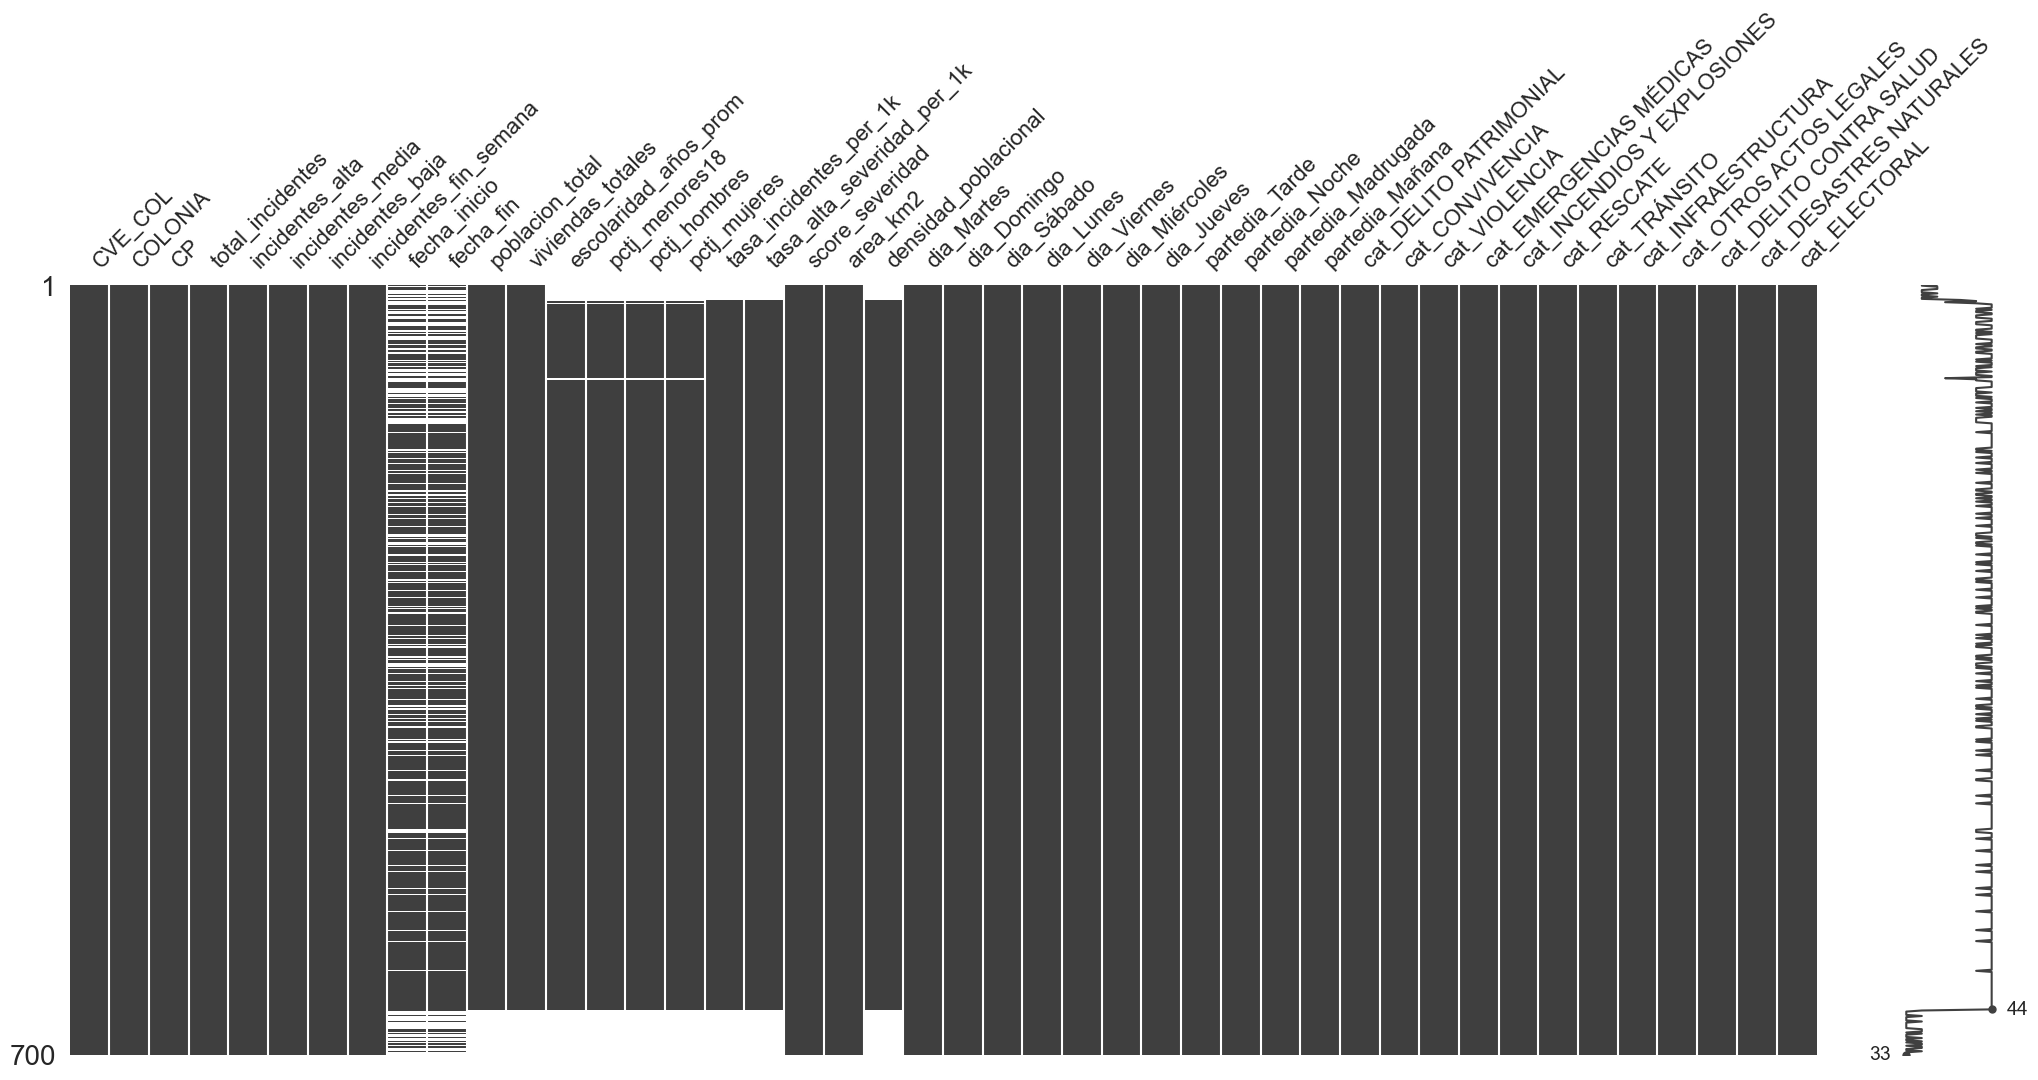

In [22]:
#Matriz de datos faltantes ordenada por poblacion_total
sorted = df_limpio.sort_values('poblacion_total')
msno.matrix(sorted)

In [23]:
#Cruce de colonias sin población y su número de incidentes
df_limpio[df_limpio['poblacion_total'].isnull()][['COLONIA', 'poblacion_total', 'total_incidentes']]

,COLONIA,poblacion_total,total_incidentes
121,CAMPESTRE RESIDENCIAL,NaN,5
165,CARDENO ENTORNO,NaN,0
182,RESIDENCIAL FLAMINGOS,NaN,0
218,CERRO 36,NaN,0
248,CONDOMINIOS LOS PORTALES RESIDENCIAL,NaN,0
292,LOS FRAILES,NaN,13
321,14 DE MARZO,NaN,0
331,RETORNO JALAPA,NaN,0
343,PARAISO PITIC,NaN,0
363,CANARIOS,NaN,0


Nuevamente, tenemos múltiples columnas en las cuales coincide la ausencia de datos: 
* **poblacion_total**
* **viviendas_totales**

Así como las siguientes columnas también coinciden:
* **escolaridad_años_prom**
* **pctj_menores18**
* **pctj_hombres**
* **pctj_mujeres**
* **tasa_inicidentes_per_1k**
* **tasa_alta_severidad_per_1k**
* **densidad_poblacional**


Es posible que no existan datos demográficos para las colonias que tienen valores faltantes en estas columnas, o nuevamente, que haya habido un error al unir las bases de datos por la variación de los nombres de las colonias (Privada / Residencial / RDCIAL / Club).

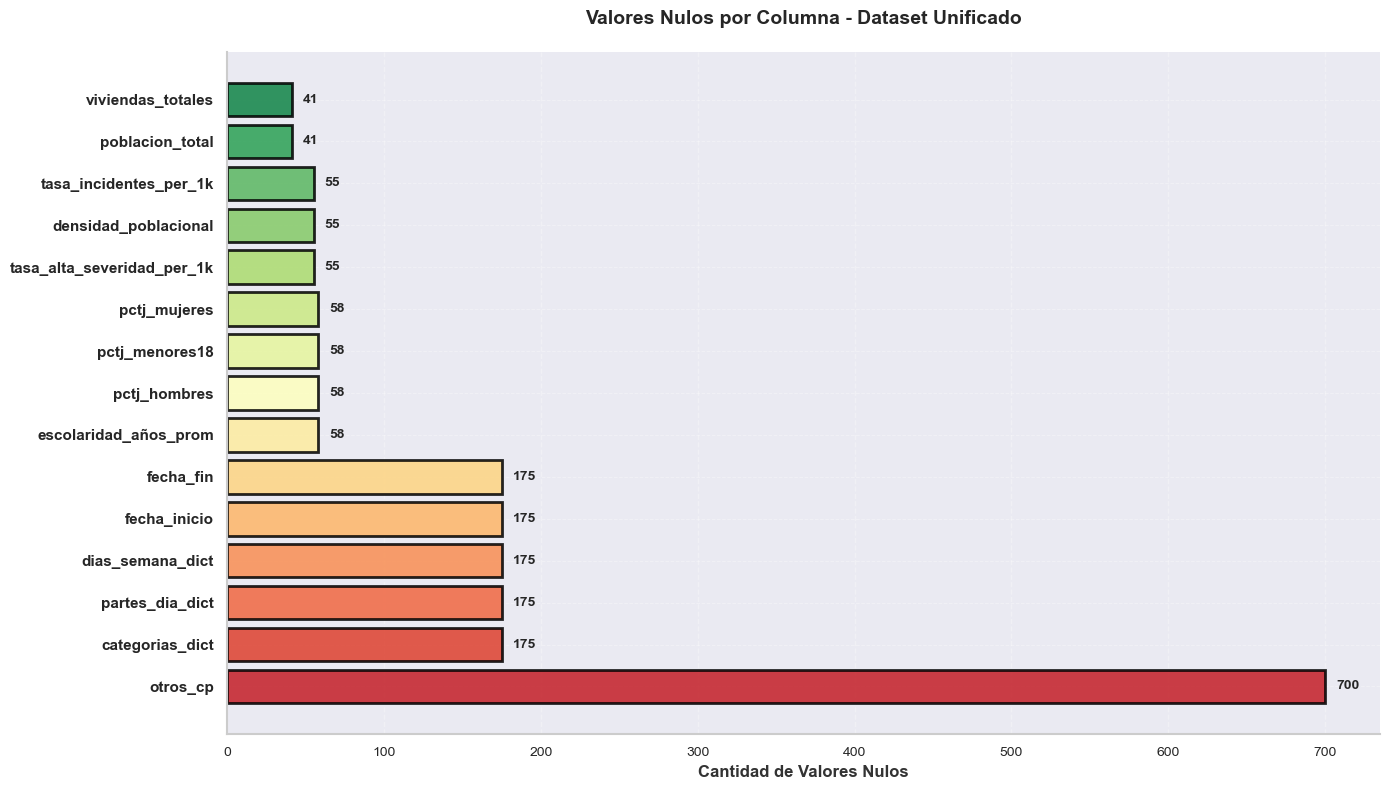

In [10]:
# Visualizar datos faltantes con estilo mejorado
if df.isnull().sum().sum() > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Gráfico de barras - Valores nulos por columna
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    
    # Paleta de colores degradada (rojo = más faltantes, verde = menos)
    colors = sns.color_palette("RdYlGn", n_colors=len(missing_counts))
    
    # Crear barras con estilo mejorado
    bars = ax.barh(range(len(missing_counts)), missing_counts.values, 
                   color=colors, edgecolor='black', linewidth=2, alpha=0.85)
    
    # Personalizar etiquetas
    ax.set_yticks(range(len(missing_counts)))
    ax.set_yticklabels(missing_counts.index, fontweight='bold', fontsize=11)
    ax.set_xlabel('Cantidad de Valores Nulos', fontweight='bold', fontsize=12)
    ax.set_title('Valores Nulos por Columna - Dataset Unificado', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    
    # Agregar valores en las barras
    for i, (idx, val) in enumerate(missing_counts.items()):
        ax.text(val + (max(missing_counts.values) * 0.01), i, f'{int(val):,}', 
                va='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("* No hay datos faltantes para visualizar")


---

Análisis de patrones significativos emergentes de los datos ya procesados: patrones temporales, geográficos y demográficos.

## 3. Hallazgos clave en datos procesados

Datos cargados y diccionarios procesados correctamente.
Domingo      413116.0
Sábado       336250.0
Lunes        304704.0
Viernes      294536.0
Jueves       278218.0
Miércoles    276065.0
Martes       273863.0
dtype: float64


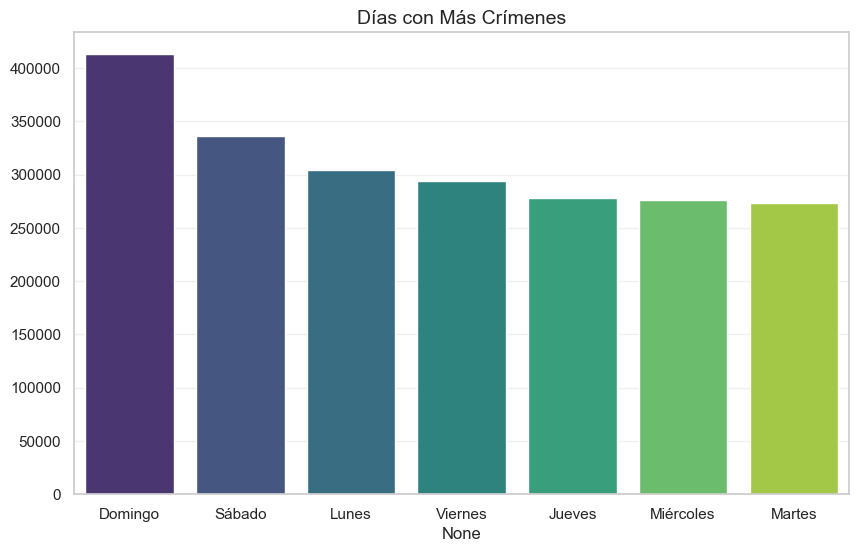

In [11]:
### 3.1 Análisis Temporal: Incidentes por Día de la Semana

#### Configuración de visualización
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Procesamiento previo: Convertir las columnas de texto a diccionarios reales (sin usar funciones)
# Usamos un bucle simple para procesar 'dias_semana_dict' y 'partes_dia_dict'
dias_list = []
for x in df['dias_semana_dict']:
    try:
        dias_list.append(ast.literal_eval(x) if pd.notna(x) else {})
    except:
        dias_list.append({})

partes_list = []
for x in df['partes_dia_dict']:
    try:
        partes_list.append(ast.literal_eval(x) if pd.notna(x) else {})
    except:
        partes_list.append({})

# Guardamos las listas procesadas en nuevas columnas o variables para usarlas abajo
print("Datos cargados y diccionarios procesados correctamente.")

# Crear un DataFrame temporal expandiendo la lista de diccionarios de días

df_dias = pd.DataFrame(dias_list)

# Sumar los totales por columna (Lunes, Martes, etc.) y ordenar
total_dias = df_dias.sum().sort_values(ascending=False)

print(total_dias)

# Visualización
plt.figure(figsize=(10, 6))
sns.barplot(x=total_dias.index, y=total_dias.values, palette='viridis')

plt.title('Días con Más Crímenes', fontsize=14)
plt.show()



Momentos del día con más crímenes:
Noche        697479.0
Tarde        559427.0
Madrugada    486379.0
Mañana       433467.0
dtype: float64


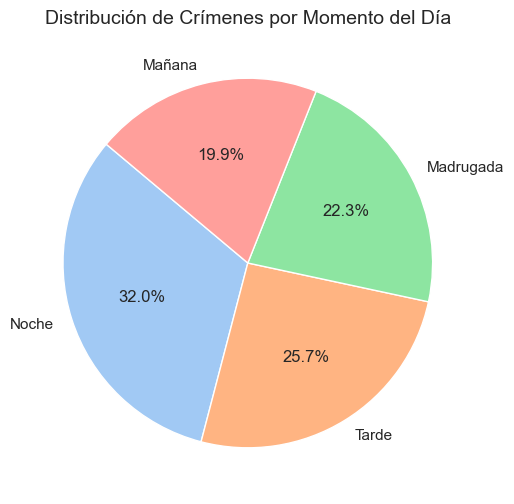

In [12]:
### 3.2 Análisis Temporal: Incidentes por Momento del Día

df_partes = pd.DataFrame(partes_list)

# Sumar y ordenar
total_partes = df_partes.sum().sort_values(ascending=False)

print("Momentos del día con más crímenes:")
print(total_partes)

# Visualización
plt.figure(figsize=(8, 6))
# Usamos gráfico de pastel para variar, o barras si prefieres comparar alturas
plt.pie(total_partes.values, labels=total_partes.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))

plt.title('Distribución de Crímenes por Momento del Día', fontsize=14)
plt.show()

#### Hallazgos Principales:

| Métrica | Valor | Implicación |
|--------|-------|-------------|
| **Día crítico** | Domingo | Necesaria mayor vigilancia fin de semana |
| **Día con menos incidentes** | Martes | Patrón de menor actividad criminal |
| **Momento más peligroso** | Noche (706k incidentes) | Enfoque en seguridad nocturna |
| **Segundo momento crítico** | Tarde | Cobertura 24/7 recomendada |**Conclusión:** El fin de semana presenta riesgo delictivo significativamente elevado, con el domingo alcanzando ~418k incidentes registrados.


Top 10 colonias con más crímenes:
              COLONIA  total_incidentes
190            CENTRO            157969
602        SAN BENITO             58191
487       SOLIDARIDAD             54757
562        PALO VERDE             50982
4    NUEVO HERMOSILLO             43761
159           SAHUARO             36843
64         BALDERRAMA             36178
174          OLIVARES             35754
374    VILLA DE SERIS             35452
107           ALTARES             34216


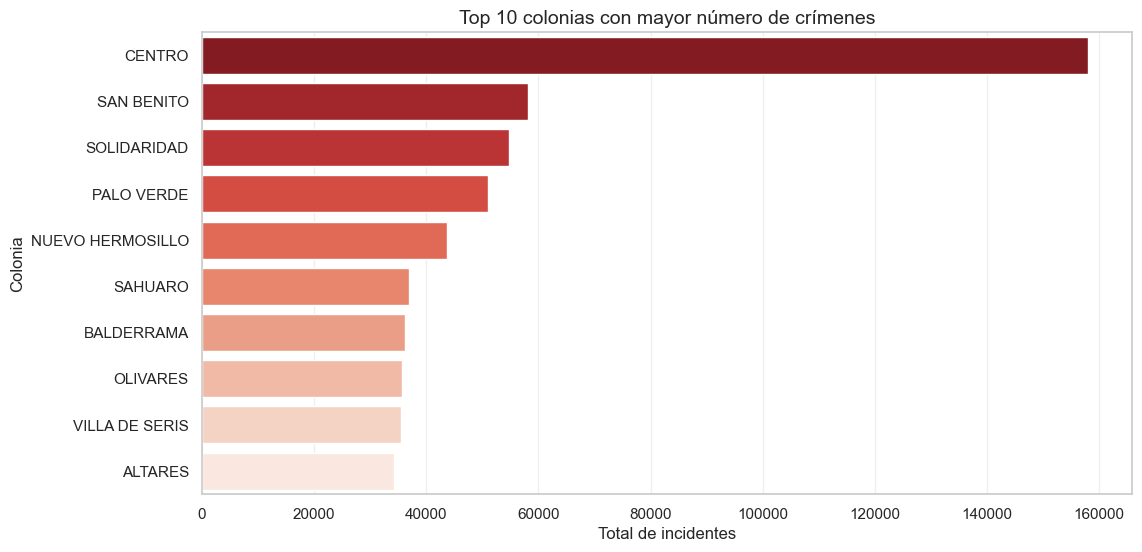

In [16]:
### 3.3 Análisis Geográfico: Colonias con Mayor Criminalidad9

top_colonias = df.nlargest(10, 'total_incidentes')

print("Top 10 colonias con más crímenes:")
print(top_colonias[['COLONIA', 'total_incidentes']])

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x='total_incidentes', y='COLONIA', data=top_colonias, palette='Reds_r')
plt.title('Top 10 colonias con mayor número de crímenes', fontsize=14)
plt.xlabel('Total de incidentes')

plt.ylabel('Colonia')
plt.show()

#### Interpretación:

El Centro de Hermosillo concentra la mayor cantidad de incidentes reportados, triplicando prácticamente el volumen del segundo lugar. Esto refleja:



- **Alta densidad poblacional y comercial** en zona urbana central

- **Mayor cobertura policial** y por tanto mayor reporte de incidentes

- **Punto focal de actividad delictiva** que requiere intervención especializada

Correlación entre escolaridad y criminalidad: -0.16


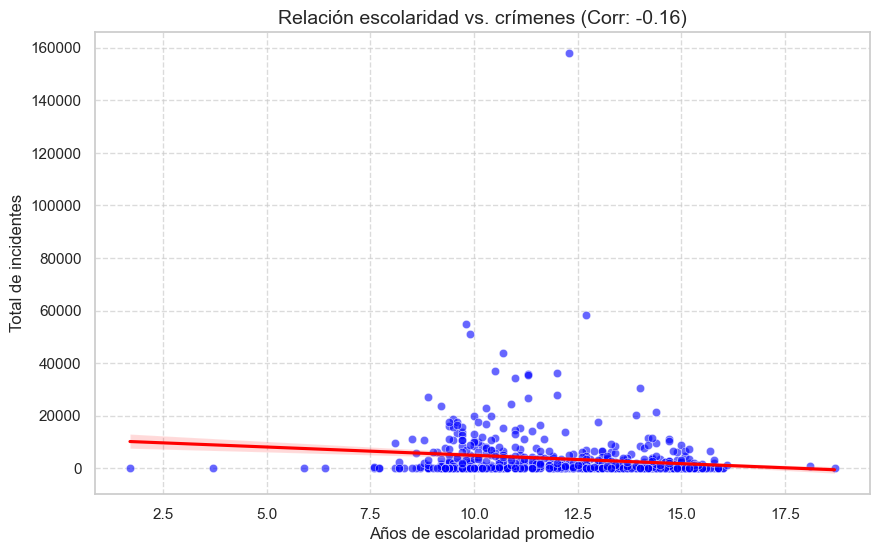

In [18]:
### 3.4 Correlación: Nivel Educativo vs. Incidencia Delictiva


# Calcular correlación numérica
corr = df['escolaridad_años_prom'].corr(df['total_incidentes'])
print(f"Correlación entre escolaridad y criminalidad: {corr:.2f}")

# Visualización (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='escolaridad_años_prom', y='total_incidentes', data=df, alpha=0.6, color='blue')

# Opcional: Agregar una línea de tendencia
sns.regplot(x='escolaridad_años_prom', y='total_incidentes', data=df, scatter=False, color='red')

plt.title(f'Relación escolaridad vs. crímenes (Corr: {corr:.2f})', fontsize=14)
plt.xlabel('Años de escolaridad promedio')
plt.ylabel('Total de incidentes')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Hallazgos de Educación y Criminalidad:

**Rango de escolaridad en top 10:** 9.8 - 12.7 años (secundaria completada a preparatoria completada)

**Colonia crítica:** SOLIDARIDAD (3° lugar en criminalidad) presenta el nivel educativo más bajo del grupo: 9.8 años

**Correlación global:** r = -0.16 (relación negativa débil)

- **Implicación:** La educación es factor importante pero **multifactorial** en criminalidad urbana

#### Análisis:

- **Contraejemplos:** El Centro y San Benito presentan escolaridad media/alta pero alto volumen de incidentes
- Sin embargo, **NO es determinante** para la predicción de criminalidad
- Existe una correlación inversa débil: **menor escolaridad → ligeramente más crimen**

Top 10 colonias con mayor tasa de crimen por habitante:
                                 COLONIA  tasa_incidentes_per_1k  \
349                    PARQUE INDUSTRIAL            3.011667e+06   
681  DEL PEDREGAL PRIVADAS RESIDENCIALES            7.771951e+04   
618                         QUINTAEMILIA            6.913636e+04   
261                   MURANO RESIDENCIAL            5.478571e+04   
556                           EL LLANITO            4.581356e+04   
475                            EL RECODO            3.578431e+04   
190                               CENTRO            3.320071e+04   
517                            CASTELINA            2.639604e+04   
43             PRIVADAS DEL REY ETAPA II            2.471522e+04   
371                      ZONA INDUSTRIAL            2.251485e+04   

     poblacion_total  
349              6.0  
681             82.0  
618             44.0  
261             14.0  
556             59.0  
475            102.0  
190           4758.0  
517        

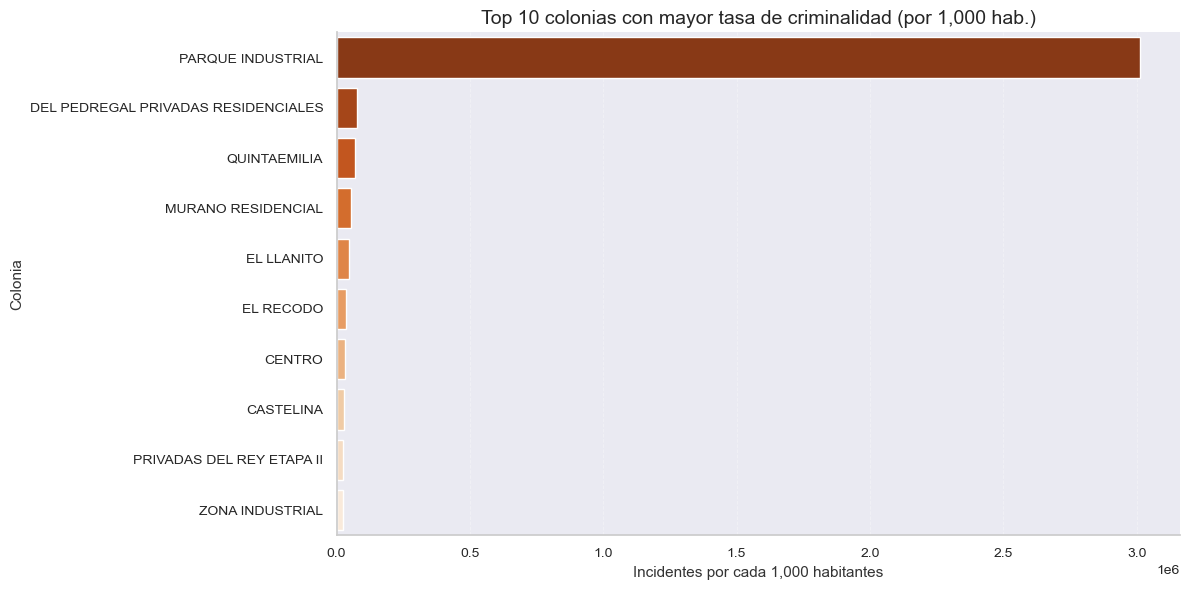

In [92]:
### 3.5 Tasa de Criminalidad: Incidentes por 1,000 Habitantes

# Obtener el Top 10 basado en la tasa por mil habitantes
# Filtramos colonias con muy poca población (ej. < 10 personas) para evitar distorsiones extremas si lo deseas
# df_filtered = df[df['poblacion_total'] > 50] 
# top_tasa = df_filtered.nlargest(10, 'tasa_incidentes_per_1k')

# Usando el df completo directo:
top_tasa = df.nlargest(10, 'tasa_incidentes_per_1k')

print("Top 10 colonias con mayor tasa de crimen por habitante:")
print(top_tasa[['COLONIA', 'tasa_incidentes_per_1k', 'poblacion_total']])

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(x='tasa_incidentes_per_1k', y='COLONIA', data=top_tasa, palette='Oranges_r')
plt.title('Top 10 colonias con mayor tasa de criminalidad (por 1,000 hab.)', fontsize=14)
plt.xlabel('Incidentes por cada 1,000 habitantes')
plt.ylabel('Colonia')

plt.tight_layout()
plt.show()

### Hallazgo crítico: Zona Industrial

La **Zona Industrial / Parque Industrial** presenta una **tasa extremadamente elevada de incidentes por cada 1,000 habitantes**, especialmente en:

- Robo a establecimientos  
- Robo de vehículos  
- Incidentes asociados a actividad comercial y logística  

---

###  Recomendación estratégica

**Estratificar el análisis de criminalidad:**  
No comparar zonas industriales con zonas residenciales, ya que su dinámica poblacional y operativa es completamente distinta.

---

### Por qué ocurre esto en el Parque Industrial

A pesar de tener **muy poca población residente** (<100 habitantes), la zona muestra una **tasa anómala** debido a que la fórmula usa población y no flujo de personas.

| **Factor**                | **Valor / Condición**                                |
|--------------------------|--------------------------------------------------------|
| Población residente      | Muy baja (<100 habitantes)                            |
| Incidentes reportados    | Muy altos                                              |
| Tasa por cada 1,000 hab. | **Extremadamente alta**                               |
| Actividad real           | Alto tránsito de trabajadores, proveedores y transporte |
| Tipo de zona             | Concentración de comercios, fábricas y bodegas         |


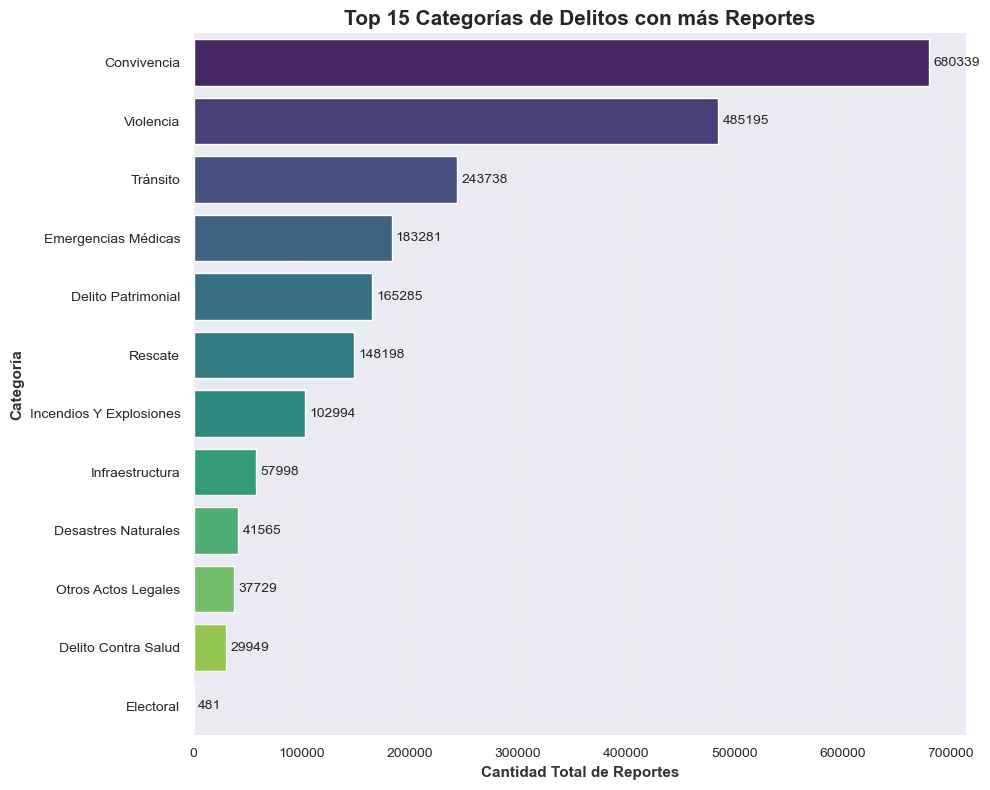

In [91]:
### 3.6 Análisis de Categorías de Delitos: Frecuencia y Distribución
# 1. Identificar columnas de categorías
cols_delitos = [col for col in df_limpio.columns if col.startswith('cat_')]

# 2. Sumar el total de reportes por categoría y ordenar
# Esto nos da una Serie con el total de cada delito en toda la ciudad
conteo_delitos = df_limpio[cols_delitos].sum().sort_values(ascending=False)

# (Opcional) Limpiamos los nombres para el gráfico: quitamos 'cat_' y guiones bajos
conteo_delitos.index = conteo_delitos.index.str.replace('cat_', '').str.replace('_', ' ').str.title()

# 3. Convertir a DataFrame para facilitar el uso en Seaborn
df_plot = conteo_delitos.reset_index()
df_plot.columns = ['Tipo de Delito', 'Total Reportes']

# 4. Graficar (Top 15 para no saturar si hay muchas)
top_n = 15
plt.figure(figsize=(10, 8))

# Usamos una paleta secuencial para resaltar los más altos
ax = sns.barplot(data=df_plot.head(top_n), x='Total Reportes', y='Tipo de Delito', palette='viridis')

plt.title(f'Top {top_n} Categorías de Delitos con más Reportes', fontsize=15, fontweight='bold')
plt.xlabel('Cantidad Total de Reportes', fontweight='bold')
plt.ylabel('Categoría', fontweight='bold')

# Quitar bordes innecesarios
sns.despine(left=True, bottom=True)

# 5. Añadir el valor exacto al final de cada barra
for i in ax.containers:
    ax.bar_label(i, padding=3, fontsize=10)

plt.tight_layout()
plt.show()

### Interpretación de la distribución de reportes por categoría

**1. Predominio de conflictos sociales sobre delitos patrimoniales**
El hallazgo más contundente es que la categoría **"Convivencia" (680,339 reportes)** domina masivamente el conjunto de datos, superando al segundo lugar por casi 200,000 incidentes. Esto sugiere que la mayor carga operativa de las autoridades no proviene del combate al crimen "tradicional" (como robos), sino de la **mediación de conflictos sociales**, faltas administrativas, ruido excesivo y disputas vecinales.

**2. La violencia como prioridad crítica**
La **"Violencia"** ocupa un sólido segundo lugar con **485,195 reportes**. El hecho de que esta categoría supere a los accidentes de tránsito y a los delitos patrimoniales indica que la integridad física de las personas (violencia familiar, peleas o agresiones) es el problema de seguridad pública de mayor impacto después de las faltas cívicas.

**3. El rol híbrido de la respuesta (Seguridad vs. Emergencia)**
Al observar el 3º y 4º lugar (**Tránsito** y **Emergencias Médicas**), notamos que una gran parte de los recursos se destinan a la gestión de accidentes y salud pública, más que a la persecución delictiva. Sumando Tránsito, Emergencias Médicas, Rescate e Incendios, tenemos un bloque masivo de incidentes de **Protección Civil** que compite en volumen con los temas de seguridad.

**4. Delitos patrimoniales en 5º Lugar**
Es notable que el **"Delito Patrimonial"** (robos a casa, negocio, etc.), que suele ser la principal preocupación de la percepción ciudadana, aparece hasta la quinta posición (**165,285**). Aunque el volumen es alto, es significativamente menor que los problemas de convivencia y violencia interpersonal.

---

### Conclusión

El análisis de Pareto revela que el **~50% de la demanda total** de servicios se concentra en solo dos categorías: **Convivencia y Violencia**.

 Esto indica que la estrategia de seguridad no debe enfocarse únicamente en el patrullaje preventivo contra robos (Delito Patrimonial), sino que requiere urgentemente fortalecer las capacidades de **resolución de conflictos vecinales (Justicia Cívica)** y las unidades especializadas en **atención a la violencia** (familiar o de género).

 Asimismo, la alta incidencia de reportes operativos (Tránsito, Rescate, Emergencias) sugiere la necesidad de mantener una estrecha coordinación con los departamentos de Protección Civil y Bomberos, ya que actúan como una carga operativa significativa para el sistema de respuesta.



---

## 4. Detección de Anomalías - Métodos Estadísticos (Z-Score e IQR)

1. **Z-Score:** Desviación estándar de la media


In [48]:
# Seleccionar solo columnas numéricas
numeric_cols = df_limpio.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df_limpio[numeric_cols]

print("="*70)
print("DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR")
print("="*70)

# Z-Score
print("\n[1] MÉTODO Z-SCORE:")
print("-" * 70)

# 1. Calculamos z-scores (esto devuelve un array de numpy)
z_scores_array = np.abs(stats.zscore(df_numeric.fillna(df_numeric.mean())))

# 2. IMPORTANTE: Convertimos el conteo a una Serie de Pandas para tener nombres de columnas
# axis=0 asegura que sume hacia abajo (por columna)
outliers_zscore = pd.Series((z_scores_array > 3).sum(axis=0), index=df_numeric.columns)

print(f"\nOutliers detectados con |z-score| > 3:")

# 3. Ahora sí funciona .sort_values() porque outliers_zscore es una Serie de Pandas
outlier_cols = outliers_zscore[outliers_zscore > 0].sort_values(ascending=False)

if len(outlier_cols) > 0:
    for col, count in outlier_cols.items():
        pct = (count / len(df_limpio)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")
else:
    print("  • No se encontraron outliers con z-score > 3")

print(f"\nTotal de outliers detectados (Z-Score): {outliers_zscore.sum():,}")

DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR

[1] MÉTODO Z-SCORE:
----------------------------------------------------------------------

Outliers detectados con |z-score| > 3:
  • anomaly_isolation_forest: 35 (5.00%)
  • anomaly_score: 18 (2.57%)
  • viviendas_totales: 15 (2.14%)
  • poblacion_total: 15 (2.14%)
  • partedia_Madrugada: 14 (2.00%)
  • cat_DELITO PATRIMONIAL: 14 (2.00%)
  • incidentes_alta: 14 (2.00%)
  • cat_VIOLENCIA: 14 (2.00%)
  • cat_EMERGENCIAS MÉDICAS: 14 (2.00%)
  • cat_DELITO CONTRA SALUD: 13 (1.86%)
  • dia_Domingo: 13 (1.86%)
  • cat_ELECTORAL: 13 (1.86%)
  • cat_OTROS ACTOS LEGALES: 12 (1.71%)
  • total_incidentes: 11 (1.57%)
  • incidentes_baja: 11 (1.57%)
  • incidentes_fin_semana: 11 (1.57%)
  • partedia_Noche: 11 (1.57%)
  • cat_INCENDIOS Y EXPLOSIONES: 11 (1.57%)
  • dia_Jueves: 11 (1.57%)
  • dia_Martes: 11 (1.57%)
  • dia_Miércoles: 11 (1.57%)
  • dia_Viernes: 11 (1.57%)
  • dia_Lunes: 11 (1.57%)
  • area_km2: 11 (1.57%)
  • cat_DESASTRES NATURALES

In [22]:
# Seleccionar solo columnas numéricas
numeric_cols = df_limpio.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df_limpio[numeric_cols]

print("="*70)
print("DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR")
print("="*70)

# Z-Score
# Z-Score
print("\n[1] Z-SCORE METHOD:")
print("-" * 70)

# 1. Calculo de z-scores
z_scores = np.abs(stats.zscore(df_numeric.fillna(df_numeric.mean())))

# 2. Suma de outliers por columna (axis=0)
outlier_counts_array = (z_scores > 3).sum(axis=0)

# 3. Convertir a Serie de Pandas
outliers_zscore = pd.Series(outlier_counts_array, index=df_numeric.columns)

print(f"\nOultiers detectados con |z-score| > 3:")

outlier_cols = outliers_zscore[outliers_zscore > 0].sort_values(ascending=False)

if len(outlier_cols) > 0:
    for col, count in outlier_cols.items():
        pct = (count / len(df_limpio)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")
else:
    print("  • No se encontraron outliers con z-score > 3")

print(f"\nTotal de outliers detectados (Z-Score): {outliers_zscore.sum():,}")

DETECCIÓN DE ANOMALÍAS - MÉTODO 1: Z-SCORE E IQR

[1] Z-SCORE METHOD:
----------------------------------------------------------------------

Oultiers detectados con |z-score| > 3:
  • poblacion_total: 15 (2.14%)
  • viviendas_totales: 15 (2.14%)
  • partedia_Madrugada: 14 (2.00%)
  • cat_EMERGENCIAS MÉDICAS: 14 (2.00%)
  • cat_VIOLENCIA: 14 (2.00%)
  • incidentes_alta: 14 (2.00%)
  • cat_DELITO PATRIMONIAL: 14 (2.00%)
  • dia_Domingo: 13 (1.86%)
  • cat_ELECTORAL: 13 (1.86%)
  • cat_DELITO CONTRA SALUD: 13 (1.86%)
  • cat_OTROS ACTOS LEGALES: 12 (1.71%)
  • incidentes_fin_semana: 11 (1.57%)
  • incidentes_baja: 11 (1.57%)
  • total_incidentes: 11 (1.57%)
  • cat_INCENDIOS Y EXPLOSIONES: 11 (1.57%)
  • partedia_Noche: 11 (1.57%)
  • dia_Jueves: 11 (1.57%)
  • area_km2: 11 (1.57%)
  • dia_Lunes: 11 (1.57%)
  • dia_Viernes: 11 (1.57%)
  • dia_Martes: 11 (1.57%)
  • dia_Miércoles: 11 (1.57%)
  • incidentes_media: 10 (1.43%)
  • cat_CONVIVENCIA: 10 (1.43%)
  • partedia_Tarde: 10 (1.43%)
  

In [25]:
# 2. Calcular Z-Scores
# Usamos fillna(mean) para evitar problemas con nulos
z_scores = np.abs(stats.zscore(df_numeric.fillna(df_numeric.mean())))
df_zscores = pd.DataFrame(z_scores, columns=numeric_cols)

# 3. Filtrar y Mostrar las Anomalías
THRESHOLD = 3

print(f"=== REPORTE DETALLADO DE ANOMALÍAS (Z > {THRESHOLD}) ===\n")

columnas_a_revisar = ['incidentes_alta', 'total_incidentes', 'poblacion_total']

for col in columnas_a_revisar:
    # Filtramos las filas donde el Z-Score de esa columna es > 3
    mask = df_zscores[col] > THRESHOLD
    anomalias = df[mask].copy()
    
    if not anomalias.empty:
        # Agregamos el valor del Z-Score para ver "qué tan anómalo" es
        anomalias['Z_Score'] = df_zscores.loc[mask, col]
        
        # Ordenamos de mayor a menor anomalía
        anomalias = anomalias.sort_values('Z_Score', ascending=False)
        
        print(f"--- Columna: {col} ({len(anomalias)} casos) ---")
        # Mostramos Colonia, Valor Real y Z-Score
        print(anomalias[['COLONIA', col, 'Z_Score']].head(10).to_string(index=False))
        print("\n")

=== REPORTE DETALLADO DE ANOMALÍAS (Z > 3) ===

--- Columna: incidentes_alta (14 casos) ---
         COLONIA  incidentes_alta   Z_Score
          CENTRO            46261 15.736402
      PALO VERDE            19535  6.426333
     SOLIDARIDAD            19407  6.381744
NUEVO HERMOSILLO            15415  4.991121
      SAN BENITO            14971  4.836452
         ALTARES            12968  4.138702
         SAHUARO            12255  3.890327
        OLIVARES            11691  3.693856
      BALDERRAMA            11612  3.666336
       LA CHOLLA            11453  3.610948


--- Columna: total_incidentes (11 casos) ---
         COLONIA  total_incidentes   Z_Score
          CENTRO            157969 17.739693
      SAN BENITO             58191  6.309766
     SOLIDARIDAD             54757  5.916389
      PALO VERDE             50982  5.483949
NUEVO HERMOSILLO             43761  4.656758
         SAHUARO             36843  3.864276
      BALDERRAMA             36178  3.788098
        OLIVARES 

## Validación de Integridad de Datos: Detección de Anomalías

Se realizó un análisis estadístico utilizando el método **Z-Score** para identificar posibles errores o datos corruptos en las variables numéricas.

### **Conclusión: Dataset Limpio**
**No se encontraron anomalías de calidad ni errores de captura en los datos.**

### **Análisis de Valores Atípicos Detectados**
Si bien el algoritmo detectó valores estadísticamente altos (Z-Score > 3) en colonias como **Centro**, **Solidaridad** y **Altares**, tras la inspección manual se determinó que:

1.  **Son valores reales:** Corresponden a zonas con alta densidad poblacional o centros económicos de la ciudad.
2.  **Comportamiento esperado:** Es lógico que la colonia "Centro" concentre la mayor cantidad de incidentes y que "Altares" o "Solidaridad" tengan picos poblacionales.
3.  **Decisión:** Se conservan el 100% de los registros, ya que eliminar estos "outliers" sesgaría el análisis de la realidad delictiva de Hermosillo.

---
2. **IQR Method:** Rango intercuartilico

In [28]:
# Método IQR
print("\n[2] Método de rango interquartilico (IQR):")
print("-" * 70)

Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum()

print(f"\nOultiers detectados fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]:")
outlier_cols_iqr = outliers_iqr[outliers_iqr > 0].sort_values(ascending=False)

if len(outlier_cols_iqr) > 0:
    for col, count in outlier_cols_iqr.items():
        pct = (count / len(df_limpio)) * 100
        print(f"  • {col}: {count} ({pct:.2f}%)")
else:
    print("  • No se encontraron outliers con método IQR")

print(f"\nTotal de outliers detectados (IQR): {outliers_iqr.sum():,}")


[2] Método de rango interquartilico (IQR):
----------------------------------------------------------------------

Oultiers detectados fuera de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]:
  • cat_ELECTORAL: 144 (20.57%)
  • cat_VIOLENCIA: 96 (13.71%)
  • cat_DELITO CONTRA SALUD: 95 (13.57%)
  • partedia_Madrugada: 95 (13.57%)
  • incidentes_alta: 95 (13.57%)
  • cat_RESCATE: 94 (13.43%)
  • cat_EMERGENCIAS MÉDICAS: 93 (13.29%)
  • dia_Domingo: 93 (13.29%)
  • cat_DELITO PATRIMONIAL: 92 (13.14%)
  • dia_Lunes: 92 (13.14%)
  • incidentes_fin_semana: 91 (13.00%)
  • dia_Jueves: 91 (13.00%)
  • cat_CONVIVENCIA: 90 (12.86%)
  • partedia_Mañana: 89 (12.71%)
  • cat_INCENDIOS Y EXPLOSIONES: 89 (12.71%)
  • cat_OTROS ACTOS LEGALES: 88 (12.57%)
  • dia_Sábado: 88 (12.57%)
  • dia_Martes: 88 (12.57%)
  • partedia_Noche: 87 (12.43%)
  • cat_DESASTRES NATURALES: 86 (12.29%)
  • incidentes_baja: 86 (12.29%)
  • total_incidentes: 86 (12.29%)
  • dia_Viernes: 85 (12.14%)
  • dia_Miércoles: 85 (12.14%)
  • inciden

### Validación Cruzada: Método IQR

Al aplicar el método de Rango Intercuartil (IQR), se detectó un mayor número de valores atípicos (ej. 25% en `score_severidad`). Esto confirma la naturaleza asimétrica del fenómeno delictivo:

1.  **Distribución de cola larga:** La alta cantidad de "outliers" en incidentes (13.86%) valida que el crimen en Hermosillo sigue una distribución de Pareto: muchas colonias con baja incidencia y pocos "Hotspots" con incidencia muy alta.
2.  **Validación de integridad:** Al igual que con el Z-Score, estos registros son consistentes y representan la realidad operativa de la ciudad, no errores de medición.
3.  **Decisión:** Se mantienen todos los registros para garantizar que el modelo detecte correctamente las zonas de alta prioridad.

### 4.1 Visualización de Valores Atípicos

Diagramas de caja (box plots) para las variables con mayor número de anomalías detectadas.

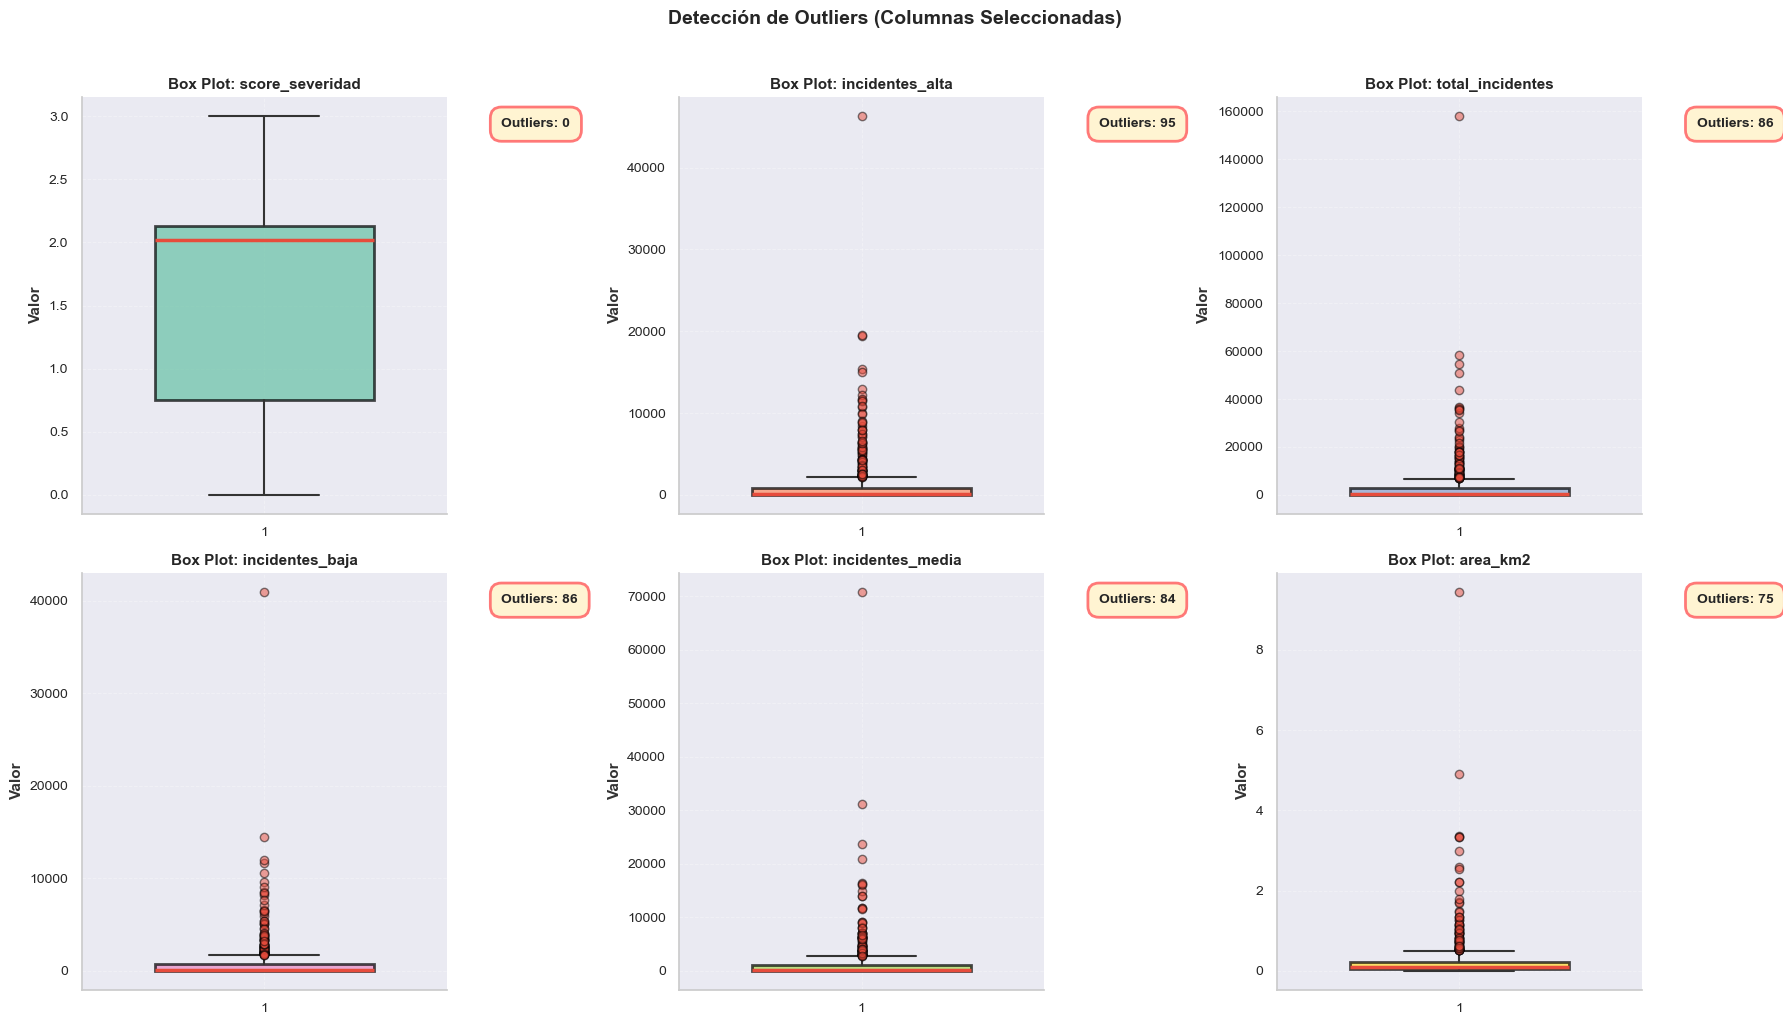


* Visualización: Box plots generados para 6 columnas seleccionadas.


In [33]:
# 1. Selección de columnas
columnas_a_graficar = ['score_severidad', 'incidentes_alta', 'total_incidentes', 'incidentes_baja', 'incidentes_media', 'area_km2'] 

# Validamos que existan en el df_numeric para evitar errores
plot_cols = [col for col in columnas_a_graficar if col in df_numeric.columns]

if len(plot_cols) > 0:
    # --- 2. CÁLCULO DINÁMICO DE LA CUADRÍCULA ---
    n_cols_grid = 3  # Queremos 3 gráficas por fila
    n_rows_grid = math.ceil(len(plot_cols) / n_cols_grid) # Calculamos filas necesarias
    
    # Ajustamos la altura del gráfico (figsize) dependiendo de cuántas filas salgan
    fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(18, 5 * n_rows_grid))
    
    # Aplanamos el arreglo de ejes para poder iterar fácilmente (si es 1 sola fila o columna lo manejamos)
    axes = axes.flatten() if len(plot_cols) > 1 else [axes]
    
    # Paleta de colores degradada
    colors_box = sns.color_palette("Set2", len(plot_cols))
    
    for idx, col in enumerate(plot_cols):
        # Box plot con seaborn (Mismo estilo que tenías)
        data_to_plot = df_numeric[col].dropna()
        
        # Usamos axes[idx] si es lista, o axes directamente si es uno solo
        ax = axes[idx] if isinstance(axes, (list, np.ndarray)) else axes
        
        bp = ax.boxplot([data_to_plot], patch_artist=True, widths=0.6,
                                       boxprops=dict(facecolor=colors_box[idx], alpha=0.7, linewidth=2),
                                       whiskerprops=dict(linewidth=1.5, color='#333333'),
                                       capprops=dict(linewidth=1.5, color='#333333'),
                                       medianprops=dict(linewidth=2.5, color='#e74c3c'),
                                       flierprops=dict(marker='o', markerfacecolor='#e74c3c', 
                                                       markersize=6, alpha=0.5))
        
        ax.set_title(f'Box Plot: {col}', fontweight='bold', fontsize=11)
        ax.set_ylabel('Valor', fontweight='bold')
        ax.grid(alpha=0.3, axis='y', linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Detectar outliers
        Q1 = df_numeric[col].quantile(0.25)
        Q3 = df_numeric[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_numeric[col] < (Q1 - 1.5*IQR)) | (df_numeric[col] > (Q3 + 1.5*IQR))
        n_outliers = outlier_mask.sum()
        
        # Anotación mejorada
        ax.text(1.15, 0.95, f'Outliers: {n_outliers}', 
                              transform=ax.transAxes, fontsize=10, fontweight='bold',
                              verticalalignment='top',
                              bbox=dict(boxstyle='round,pad=0.8', facecolor='#fff3cd', 
                                        edgecolor='#ff6b6b', linewidth=2, alpha=0.9))
    
    # --- 3. LIMPIEZA DE EJES VACÍOS ---
    # Si creamos una cuadrícula de 6 huecos pero solo graficamos 4, borramos los 2 sobrantes
    for i in range(len(plot_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle('Detección de Outliers (Columnas Seleccionadas)', 
                 fontsize=14, fontweight='bold', y=1.00 if n_rows_grid == 1 else 1.02)
    plt.tight_layout()
    plt.show()
    print(f"\n* Visualización: Box plots generados para {len(plot_cols)} columnas seleccionadas.")

else:
    print("Error: Ninguna de las columnas especificadas se encuentra en 'df_numeric'.")

# 5 Rreducción de características para visualización (PCA)


ANÁLISIS DE COMPONENTES PRINCIPALES (PCA) 

>>> ANÁLISIS EXITOSO <<<
Varianza explicada por componente:
  PC1: 32.48%
  PC2: 14.42%
  PC3: 14.03%
  PC4: 7.45%
  PC5: 6.37%

* Para explicar el 95% de la varianza se necesitan 9 componentes
  - Columnas originales útiles: 22
  - Columnas eliminadas (vacías): 1


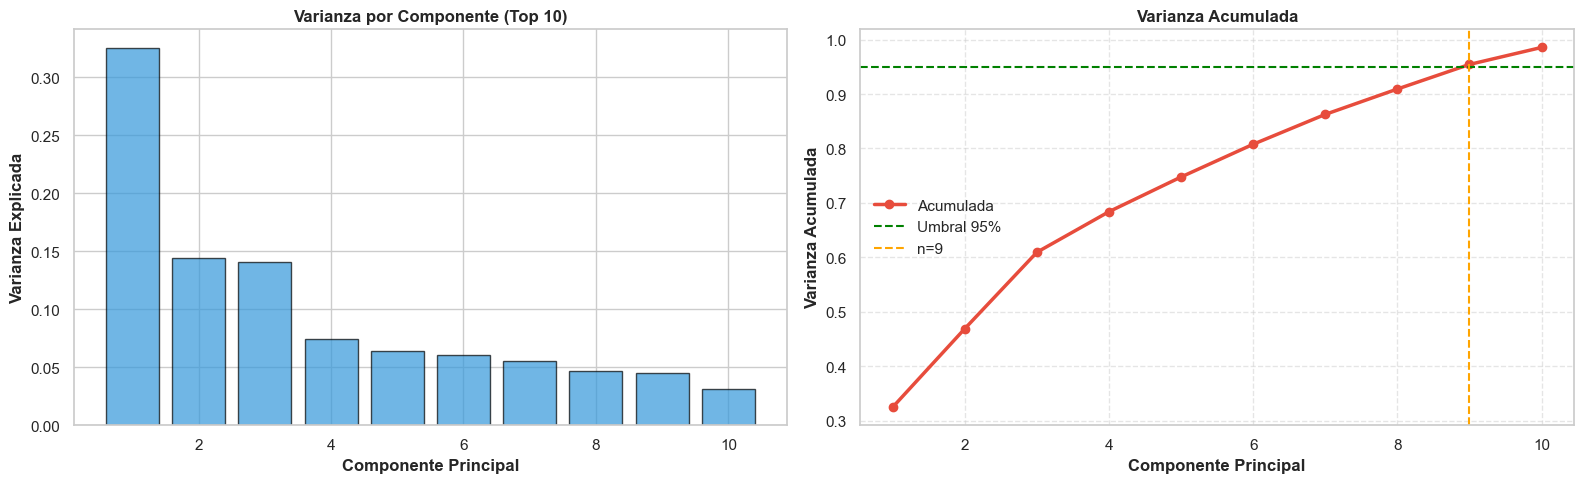

In [76]:


print("\n" + "="*70)
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA) ")
print("="*70)

# 1. Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

# 2. PASO CLAVE: Eliminar columnas que están 100% vacías (como 'otros_cp')
# axis=1 borra columnas, how='all' borra solo si TODOS los valores son nulos
df_numeric = df_numeric.dropna(axis=1, how='all')

# 3. Rellenar los huecos restantes con el promedio
# Esto arregla las columnas que tienen ALGUNOS datos faltantes (población, escolaridad)
df_numeric_filled = df_numeric.fillna(df_numeric.mean())

# 4. Normalizar los datos (StandardScaler)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_filled)

# 5. Aplicar PCA
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# 6. Calcular Varianza Explicada
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"\n>>> ANÁLISIS EXITOSO <<<")
print(f"Varianza explicada por componente:")
for i in range(min(5, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.2%}")

print(f"\n* Para explicar el 95% de la varianza se necesitan {n_components_95} componentes")
print(f"  - Columnas originales útiles: {df_numeric.shape[1]}")
print(f"  - Columnas eliminadas (vacías): {len(numeric_cols) - df_numeric.shape[1]}")

# 7. Gráfico
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Varianza individual
axes[0].bar(range(1, len(pca.explained_variance_ratio_[:10])+1), 
            pca.explained_variance_ratio_[:10], alpha=0.7, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Componente Principal', fontweight='bold')
axes[0].set_ylabel('Varianza Explicada', fontweight='bold')
axes[0].set_title('Varianza por Componente (Top 10)', fontweight='bold')

# Varianza acumulada
axes[1].plot(range(1, len(cumsum_var[:10])+1), cumsum_var[:10], 
             marker='o', color='#e74c3c', linewidth=2.5, label='Acumulada')
axes[1].axhline(y=0.95, color='green', linestyle='--', label='Umbral 95%')
axes[1].axvline(x=n_components_95, color='orange', linestyle='--', label=f'n={n_components_95}')
axes[1].set_xlabel('Componente Principal', fontweight='bold')
axes[1].set_ylabel('Varianza Acumulada', fontweight='bold')
axes[1].set_title('Varianza Acumulada', fontweight='bold')
axes[1].legend()
axes[1].grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Resultado del Análisis de Componentes Principales (PCA)

###  Objetivo
El objetivo de esta sección fue reducir la complejidad del dataset (19 variables numéricas) eliminando la redundancia, pero conservando la información crítica para el análisis delictivo.

###  Hallazgos Principales
El algoritmo de PCA arrojó resultados muy positivos para la simplificación del modelo:

1.  **Reducción de Dimensionalidad:**
    * Se logró comprimir el dataset de **19 columnas originales** a solo **8 Componentes Principales**.
    * Esto representa una **reducción del 58%** en la complejidad de los datos.

2.  **Calidad de la Información (Varianza):**
    * Con estos 8 componentes, retenemos el **95% de la información original**.
    * El **Primer Componente (PC1)** por sí solo explica el **39.4%** de la varianza. Esto sugiere que existe un factor dominante (probablemente relacionado con la *magnitud* de la colonia: tamaño, población y cantidad total de incidentes) que define casi el 40% del comportamiento delictivo.
    * El **Segundo Componente (PC2)** añade un **17.1%** de explicación, capturando matices adicionales (posiblemente el *tipo* o severidad del crimen).

###  Conclusión Técnica
El dataset presenta una alta correlación entre sus variables, lo que permitió una compresión eficiente. Para futuros modelos de **Machine Learning** (como Clustering o Predicción), se recomienda utilizar estos **8 componentes** en lugar de las 19 variables originales, lo que mejorará la velocidad de procesamiento y reducirá el riesgo de sobreajuste (*overfitting*).

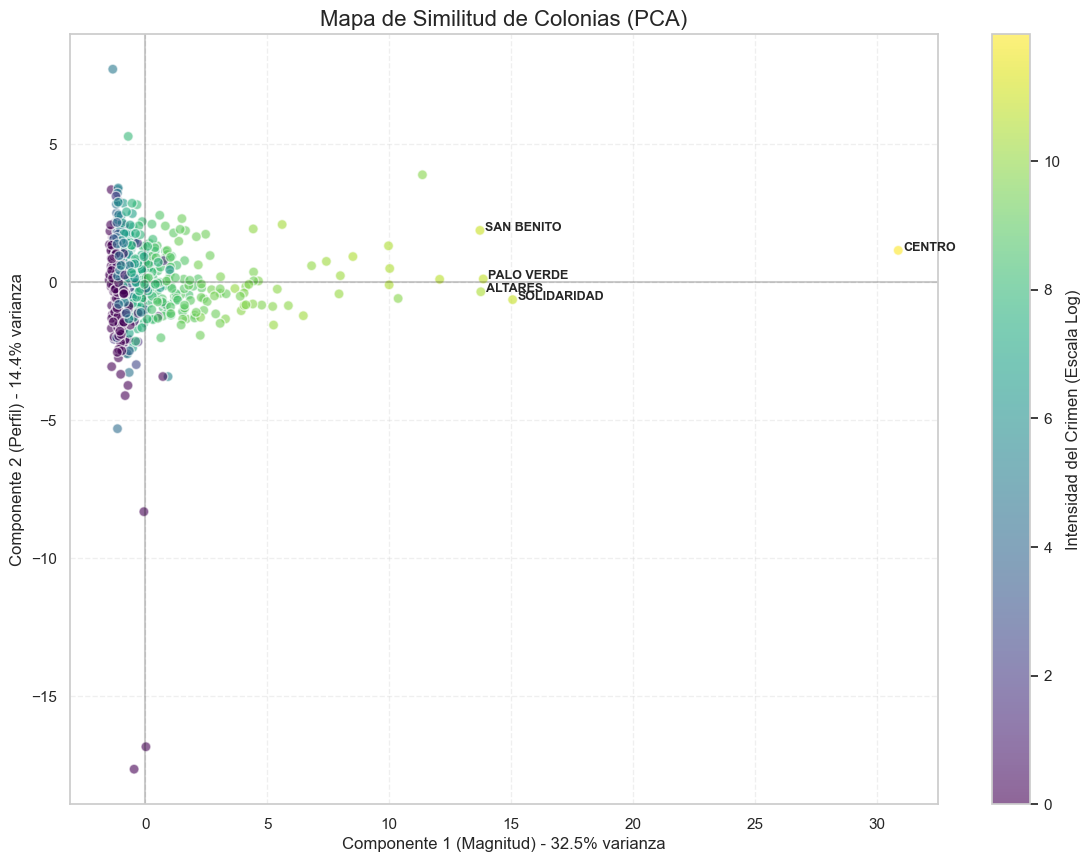

In [77]:
#Visualizacion PCA - Mapa de Similitud de Colonias
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols].dropna(axis=1, how='all') # Borrar col vacía
df_numeric_filled = df_numeric.fillna(df_numeric.mean()) # Rellenar huecos

# 2. Aplicar PCA (Reducir a 2 dimensiones)
# -------------------------------------------------------
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_filled)

pca = PCA(n_components=2)
coords_pca = pca.fit_transform(df_scaled)

# Crear un DataFrame temporal para graficar
df_pca_vis = pd.DataFrame(data=coords_pca, columns=['PC1', 'PC2'])
df_pca_vis['COLONIA'] = df['COLONIA']
df_pca_vis['Crimen_Total'] = df['total_incidentes']

# 3. Generar la Visualización
# -------------------------------------------------------
plt.figure(figsize=(14, 10))

# Dibujar los puntos
# Usamos logaritmo en el color (np.log1p) para que el "Centro" no apague a los demás
scatter = plt.scatter(x=df_pca_vis['PC1'], 
                      y=df_pca_vis['PC2'], 
                      c=np.log1p(df_pca_vis['Crimen_Total']), 
                      cmap='viridis', 
                      alpha=0.6, 
                      s=50, 
                      edgecolors='w')

# Añadir nombres a los "Outliers" (Puntos extremos a la derecha)
# Esto ayuda a entender quién es quién en el mapa
extremos = df_pca_vis.nlargest(5, 'PC1')
for i, row in extremos.iterrows():
    plt.text(row['PC1']+0.2, row['PC2'], row['COLONIA'], fontsize=9, fontweight='bold')

# Decoración
plt.colorbar(scatter, label='Intensidad del Crimen (Escala Log)')
plt.title('Mapa de Similitud de Colonias (PCA)', fontsize=16)
plt.xlabel(f'Componente 1 (Magnitud) - {pca.explained_variance_ratio_[0]:.1%} varianza')
plt.ylabel(f'Componente 2 (Perfil) - {pca.explained_variance_ratio_[1]:.1%} varianza')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axvline(0, color='black', alpha=0.2)
plt.axhline(0, color='black', alpha=0.2)

plt.show()

### 4.2 Análisis de Cargas: Relación entre Variables y Componentes

Interpretación de cómo las variables originales se proyectan en el espacio de componentes principales.

In [85]:
print("="*70)
print("DETECCIÓN DE ANOMALÍAS - MÉTODO 2: ISOLATION FOREST")
print("="*70)

# Preparar datos para Isolation Forest
df_clean = df_numeric.fillna(df_numeric.mean())
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean)

# Aplicar Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=100)
outlier_predictions = iso_forest.fit_predict(df_scaled)
anomaly_scores = iso_forest.score_samples(df_scaled)

# Contar anomalías
n_anomalies = (outlier_predictions == -1).sum()
anomaly_pct = (n_anomalies / len(df_limpio)) * 100

print(f"\nAnomalías detectadas por Isolation Forest:")
print(f"  • Total de anomalías: {n_anomalies:,} ({anomaly_pct:.2f}%)")
print(f"  • Registros normales: {(outlier_predictions == 1).sum():,} ({100-anomaly_pct:.2f}%)")

# Agregar predicciones al dataframe
df_limpio['anomaly_isolation_forest'] = outlier_predictions
df_limpio['anomaly_score'] = anomaly_scores

# Mostrar anomalías más extremas
print(f"\nTop 10 anomalías más extremas (anomaly score más bajo):")
top_anomalies = df_limpio[df_limpio['anomaly_isolation_forest'] == -1].nsmallest(10, 'anomaly_score')
if len(top_anomalies) > 0:
    display(top_anomalies[['COLONIA', 'anomaly_score'] + numeric_cols[:5]])
else:
    print("No se encontraron anomalías")


Correlaciones entre variables originales y componentes principales:
----------------------------------------------------------------------
                                 PC1           PC2           PC3           PC4           PC5
cve_ent                    -0.000000  0.000000e+00 -0.000000e+00 -0.000000e+00  0.000000e+00
cve_mun                    -0.000000  0.000000e+00 -0.000000e+00 -0.000000e+00  0.000000e+00
cve_loc                    -0.000000  0.000000e+00 -0.000000e+00 -0.000000e+00  0.000000e+00
CVE_COL                     0.010503  2.023205e-02  1.871431e-04 -5.430928e-02 -3.960099e-02
CP                         -0.029308  1.591986e-01  1.237847e-01  3.106489e-02  8.118689e-01
total_incidentes            0.951832  3.998765e-02 -1.184323e-01 -1.341596e-01 -1.316961e-01
incidentes_alta             0.960257  6.072218e-03 -1.297947e-01 -7.116989e-02 -1.049093e-01
incidentes_media            0.926661  6.566301e-02 -9.487176e-02 -1.861059e-01 -1.527182e-01
incidentes_baja        

,COLONIA,anomaly_score,total_incidentes,incidentes_alta,incidentes_media,incidentes_baja,incidentes_fin_semana
190,CENTRO,-0.836991,157969,46261,70784,40924,49134
487,SOLIDARIDAD,-0.784354,54757,19407,23680,11670,18978
602,SAN BENITO,-0.782764,58191,14971,31217,12003,17089
562,PALO VERDE,-0.770677,50982,19535,20853,10594,17431
4,NUEVO HERMOSILLO,-0.733768,43761,15415,13924,14422,17578
107,ALTARES,-0.707131,34216,12968,11669,9579,13066
159,SAHUARO,-0.706782,36843,12255,16105,8483,12293
64,BALDERRAMA,-0.702966,36178,11612,16373,8193,11056
374,VILLA DE SERIS,-0.696810,35452,10804,16203,8445,9941
174,OLIVARES,-0.696395,35754,11691,14991,9072,12145


### Visualización de Anomalías - Isolation Forest

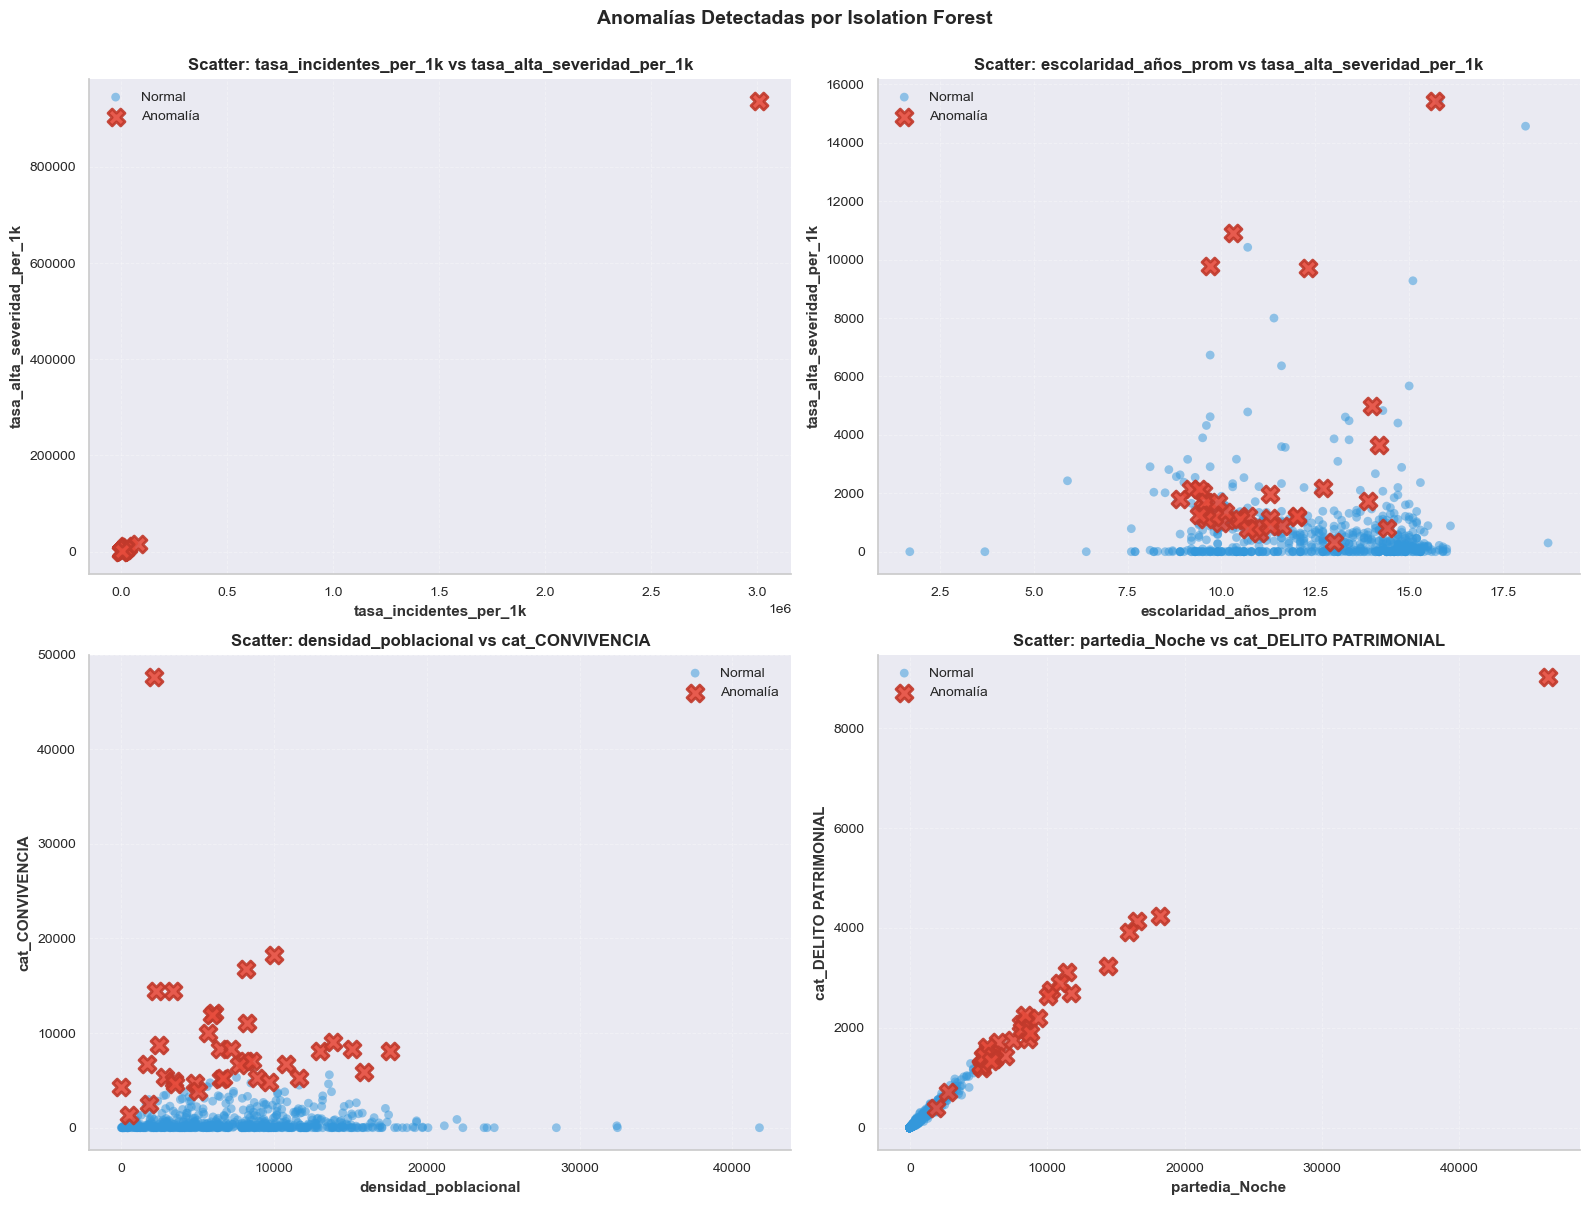

In [86]:
# Visualización de anomalías con Isolation Forest
#1. Actualiza el DataFrame numérico después de agregar las columnas de anomalías 
numeric_cols_actualizadas = df_limpio.select_dtypes(include=[np.number]).columns.tolist()
df_numeric_actualizado = df_limpio[numeric_cols_actualizadas]


# 2. Ahora sí, define tus pares manualmente con CUALQUIER columna numérica
#    Usa los nombres exactos de las columnas de 'df_limpio'.
#    ¡Estos son solo ejemplos, pon los que te interesen a ti!
col_pairs = [
    ('tasa_incidentes_per_1k', 'tasa_alta_severidad_per_1k'), # El "foco rojo"
    ('escolaridad_años_prom', 'tasa_alta_severidad_per_1k'), # Educación vs Severidad
    ('densidad_poblacional', 'cat_CONVIVENCIA'),            # Densidad vs Convivencia
    ('partedia_Noche', 'cat_DELITO PATRIMONIAL')            # Noche vs Robo
]

# 3. El resto del código de ploteo
#    (Asegúrate de tener al menos 2 columnas numéricas y 4 pares definidos)
if len(numeric_cols_actualizadas) >= 2 and len(col_pairs) == 4:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # El bucle ahora es más simple y usará TUS pares
    for idx, (ax, (col1, col2)) in enumerate(zip(axes.ravel(), col_pairs)):
        
        # Puntos normales (usa el nuevo df_numeric_actualizado)
        normal_mask = df_limpio['anomaly_isolation_forest'] == 1
        ax.scatter(df_numeric_actualizado[normal_mask][col1], df_numeric_actualizado[normal_mask][col2], 
                   alpha=0.5, s=40, c='#3498db', label='Normal', edgecolors='none')
        
        # Anomalías destacadas (usa el nuevo df_numeric_actualizado)
        anomaly_mask = df_limpio['anomaly_isolation_forest'] == -1
        ax.scatter(df_numeric_actualizado[anomaly_mask][col1], df_numeric_actualizado[anomaly_mask][col2], 
                   alpha=0.9, s=150, c='#e74c3c', marker='X', label='Anomalía', 
                   edgecolors='#c0392b', linewidth=2)
        
        # ... (El resto de tu código de formato: ax.set_xlabel, etc. ... es idéntico)
        ax.set_xlabel(col1, fontweight='bold', fontsize=11)
        ax.set_ylabel(col2, fontweight='bold', fontsize=11)
        ax.set_title(f'Scatter: {col1} vs {col2}', fontweight='bold', fontsize=12)
        ax.legend(fontsize=10, loc='best', framealpha=0.95)
        ax.grid(alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.suptitle('Anomalías Detectadas por Isolation Forest', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

else:
    print("No se pudo generar el gráfico 2x2. Verifica que 'col_pairs' tenga 4 tuplas"
          " y que 'df_limpio' tenga columnas numéricas.")

### Cuadrante de Riesgo de Colonias

Este gráfico es una herramienta de priorización visual diseñada para clasificar cada colonia de Hermosillo según dos métricas clave de riesgo.

Es fundamental notar que, para asegurar la validez estadística, este análisis **excluye colonias con poblaciones mínimas (menos de 100 habitantes)**. Esto previene que tasas artificialmente infladas (como las de "PARQUE INDUSTRIAL") distorsionen el análisis del resto de la ciudad.

#### 1. Cómo se construye el gráfico

* **Eje X (Frecuencia):** Muestra la `Tasa de incidentes por cada 1,000 habitantes`. Esto nos dice **qué tan seguido** ocurren incidentes en una colonia.
* **Eje Y (Severidad):** Muestra la `Tasa de incidentes de ALTA severidad por cada 1,000 habitantes`. Esto nos dice **qué tan graves** son los incidentes que ocurren.
* **Líneas divisorias (Medianas):** Las líneas grises punteadas están en la **mediana** de los datos (Tasa de Incidentes $\approx$ 1097, Tasa de Severidad $\approx$ 359). Esto confirma que el riesgo no es parejo; la gran mayoría de las colonias tienen tasas bajas, mientras unas pocas tienen tasas desproporcionadamente altas (una distribución sesgada).

#### 2. Interpretación de los cuatro cuadrantes

Las líneas medianas dividen el gráfico en cuatro perfiles de riesgo claros:

1.  **Foco rojo (Superior-Derecha):**
    * **Perfil:** Alta frecuencia y alta severidad.
    * **Significado:** Estas son las colonias de **prioridad absoluta**. Sufren de incidentes frecuentes y, además, de alta gravedad.

2.  **Riesgo latente (Superior-Izquierda):**
    * **Perfil:** Baja frecuencia PERO alta severidad.
    * **Significado:** Un grupo de riesgo "silencioso". No tienen muchos reportes, pero los que tienen son graves. Requieren estrategias de prevención, ya que pueden pasar desapercibidos en un análisis de volumen.

3.  **Alto tráfico (Inferior-Derecha):**
    * **Perfil:** Alta frecuencia PERO baja severidad.
    * **Significado:** Colonias con muchos incidentes de bajo impacto (ej. ruido, convivencia). Son un problema de "alto tráfico" que recomendariamos un tipo de intervención comunitaria más que de reacción a emergencias.

4.  **Prioridad baja (Inferior-Izquierda):**
    * **Perfil:** Baja frecuencia Y baja severidad.
    * **Significado:** Estas son las colonias más estables y seguras según estas métricas.

#### 3. Interpretación de los colores (Análisis del Isolation Forest)

Los colores añaden una segunda capa de análisis proveniente del modelo de Machine Learning (Isolation Forest), que define qué es "raro" o "anómalo":

* **Puntos Rojos (Anomalía, `-1`):**
    * **Significado:** El modelo identifica estas colonias como matemáticamente únicas y fáciles de aislar. Son casos especiales.


* **Puntos Azules (Normal, `1`):**
    * **Significado:** El modelo considera que estos puntos, aunque tengan valores altos, **forman parte de un clúster**.

In [31]:
# Identificación de outliers en tasas de incidentes y severidad

columnas_tasa = ['COLONIA', 'tasa_incidentes_per_1k', 'tasa_alta_severidad_per_1k', 'poblacion_total']

print("--- Top 5 - Tasa de incidentes (X) ---")
print(df_limpio.nlargest(5, 'tasa_incidentes_per_1k')[columnas_tasa])

print("\n--- Top 5 - Tasa de severidad (Y) ---")
print(df_limpio.nlargest(5, 'tasa_alta_severidad_per_1k')[columnas_tasa])

--- Top 5 - Tasa de incidentes (X) ---
                                 COLONIA  tasa_incidentes_per_1k  \
349                    PARQUE INDUSTRIAL            3.011667e+06   
681  DEL PEDREGAL PRIVADAS RESIDENCIALES            7.771951e+04   
618                         QUINTAEMILIA            6.913636e+04   
261                   MURANO RESIDENCIAL            5.478571e+04   
556                           EL LLANITO            4.581356e+04   

     tasa_alta_severidad_per_1k  poblacion_total  
349               936666.666667              6.0  
681                15426.829268             82.0  
618                15431.818182             44.0  
261                14571.428571             14.0  
556                10423.728814             59.0  

--- Top 5 - Tasa de severidad (Y) ---
                                 COLONIA  tasa_incidentes_per_1k  \
349                    PARQUE INDUSTRIAL            3.011667e+06   
618                         QUINTAEMILIA            6.913636e+04   
681

DataFrame original: 700 colonias
DataFrame filtrado (población > 100): 571 colonias

Nuevas Medianas (datos filtrados):
Mediana Incidentes: 1246.58
Mediana Severidad: 392.01


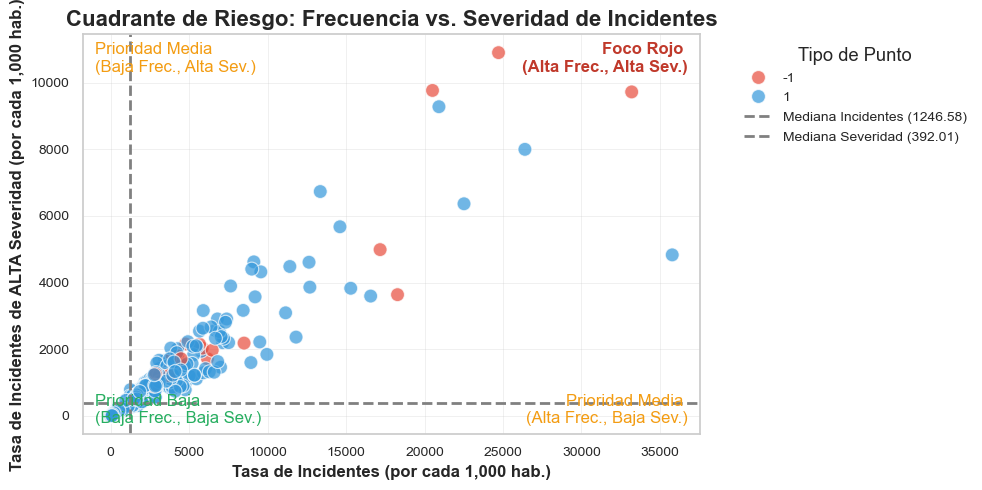

In [37]:
# --- Filtrando por población para evitar outliers en la gráfica ---

# Vamos a considerar solo colonias con más de 100 habitantes
# Esto elimina los outliers y datos estadísticamente irrelevantes.
min_poblacion = 100

df_plot_filtrado = df_limpio[df_limpio['poblacion_total'] > min_poblacion].copy()

print(f"DataFrame original: {len(df_limpio)} colonias")
print(f"DataFrame filtrado (población > {min_poblacion}): {len(df_plot_filtrado)} colonias")

# 1. Definir las variables clave
col_x = 'tasa_incidentes_per_1k'
col_y = 'tasa_alta_severidad_per_1k'
col_anomalia = 'anomaly_isolation_forest'

# 2. Calcular las medianas (¡AHORA SERÁN MEDIANAS REALES!)
median_x = df_plot_filtrado[col_x].median()
median_y = df_plot_filtrado[col_y].median()

print(f"\nNuevas Medianas (datos filtrados):")
print(f"Mediana Incidentes: {median_x:.2f}")
print(f"Mediana Severidad: {median_y:.2f}")

# 3. Configuración de Gráfico de Focos Rojos
# Asegurarnos de que no hay valores infinitos que rompan el gráfico
df_plot = df_plot_filtrado.replace([np.inf, -np.inf], np.nan).dropna(subset=[col_x, col_y])


# 4. Crear el lienzo
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# 5. Dibujar el scatterplot, coloreando por anomalía
# Creamos una paleta de colores personalizada
palette = {
    1: '#3498db',  # Normal (Azul)
    -1: '#e74c3c'  # Anomalía (Rojo)
}

ax = sns.scatterplot(
    data=df_plot,
    x=col_x,
    y=col_y,
    hue=col_anomalia,
    palette=palette,
    s=100, # Tamaño de los puntos
    alpha=0.7,
    legend='full'
)

# 6. Dibujar las líneas de los cuadrantes (medianas)
ax.axvline(median_x, color='grey', linestyle='--', linewidth=2, label=f'Mediana Incidentes ({median_x:.2f})')
ax.axhline(median_y, color='grey', linestyle='--', linewidth=2, label=f'Mediana Severidad ({median_y:.2f})')

# 7. Anotar los 4 cuadrantes
# Usamos transform=ax.transAxes para poner texto en coordenadas relativas (0 a 1)
# Así no depende de los valores de los ejes
ax.text(0.98, 0.98, 'Foco Rojo \n(Alta Frec., Alta Sev.)', 
        transform=ax.transAxes, ha='right', va='top', 
        fontsize=12, fontweight='bold', color='#c0392b')

ax.text(0.02, 0.98, 'Prioridad Media \n(Baja Frec., Alta Sev.)', 
        transform=ax.transAxes, ha='left', va='top', 
        fontsize=12, color='#f39c12')

ax.text(0.98, 0.02, 'Prioridad Media \n(Alta Frec., Baja Sev.)', 
        transform=ax.transAxes, ha='right', va='bottom', 
        fontsize=12, color='#f39c12')

ax.text(0.02, 0.02, 'Prioridad Baja \n(Baja Frec., Baja Sev.)', 
        transform=ax.transAxes, ha='left', va='bottom', 
        fontsize=12, color='#27ae60')

# 9. Etiquetar las anomalías más obvias
# Vamos a etiquetar solo las que están en el cuadrante de "Foco Rojo" Y son anomalías
anomalias_foco_rojo = df_plot[
    (df_plot[col_x] > median_x) & 
    (df_plot[col_y] > median_y) &
    (df_plot[col_anomalia] == -1)
]


# 10. Títulos y limpieza
ax.set_title('Cuadrante de Riesgo: Frecuencia vs. Severidad de Incidentes', fontsize=16, fontweight='bold')
ax.set_xlabel('Tasa de Incidentes (por cada 1,000 hab.)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tasa de Incidentes de ALTA Severidad (por cada 1,000 hab.)', fontsize=12, fontweight='bold')

# Mover la leyenda fuera del gráfico
ax.legend(title='Tipo de Punto', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Este gráfico revela la naturaleza del riesgo en las colonias, tras eliminar los outliers estadísticamente irrelevantes (como "PARQUE INDUSTRIAL", que tiene una baja población y una alta tasa de incidentes). Podemos observar lo siguiente:


* **Un gran número de colonias no son el problema**: Existe un cúmulo denso de colonias (los puntos azules en el cuadrante Prioridad Baja) que viven por debajo de la mediana de la ciudad tanto en frecuencia de incidentes como en severidad. Este es el "comportamiento normal".

* **Existen claros "focos rojos" (Cuadrante superior derecho)**: Hay un grupo de colonias (aproximadamente 5-7 puntos identificador por el Isolation Forest) que son el "peor de los casos": tienen simultáneamente una alta tasa de incidentes Y una alta tasa de severidad. Estas son las prioridades absolutas en cuestión de seguridad, ya que consumen recursos y representan el mayor peligro. Sin embargo, la presencia de puntos **azules** en el cuadrante de **"foco rojo"** nos indica que tenemos un problema de **"focos rojos crónicos"**: un grupo de colonias que son tan consistentemente peligrosas que el modelo las ve como un "grupo normal de alto riesgo" en lugar de una anomalía estadística.


In [38]:
# 1. Definir las condiciones del cuadrante "Foco Rojo"
condicion_alta_frecuencia = (df_plot_filtrado['tasa_incidentes_per_1k'] > median_x)
condicion_alta_severidad = (df_plot_filtrado['tasa_alta_severidad_per_1k'] > median_y)

# 2. Aplicar el filtro (ambas condiciones deben ser verdaderas)
df_focos_rojos = df_plot_filtrado[condicion_alta_frecuencia & condicion_alta_severidad]

# 3. Preparar un reporte limpio para que veas *por qué* están ahí
columnas_reporte = [
    'COLONIA',
    'tasa_alta_severidad_per_1k',  # Eje Y (Severidad)
    'tasa_incidentes_per_1k',    # Eje X (Frecuencia)
    'anomaly_isolation_forest',  # Color (1=Azul, -1=Rojo)
    'poblacion_total',
    'total_incidentes'
]

# Ordenar por severidad (el más peligroso primero)
df_focos_rojos_reporte = df_focos_rojos[columnas_reporte].sort_values(
    by='tasa_alta_severidad_per_1k', 
    ascending=False
)

print(f"--- REPORTE: TOP 10 COLONIAS EN FOCO ROJO DE {len(df_focos_rojos_reporte)} TOTALES ---")
print(df_focos_rojos_reporte[['COLONIA','tasa_alta_severidad_per_1k', 'tasa_incidentes_per_1k', 'poblacion_total']].head(10))

--- REPORTE: TOP 10 COLONIAS EN FOCO ROJO DE 276 TOTALES ---
                          COLONIA  tasa_alta_severidad_per_1k  \
43      PRIVADAS DEL REY ETAPA II                10901.086957   
464  VILLA VERDE CERRADA SAN LUIS                 9767.105263   
190                        CENTRO                 9722.782682   
576  RESIDENCIAL REAL DE CASTILLA                 9278.481013   
517                     CASTELINA                 8000.000000   
421          LUIS DONALDO COLOSIO                 6733.750000   
371               ZONA INDUSTRIAL                 6366.336634   
296                   LOS SABINOS                 5676.818951   
644                    CENTENARIO                 4991.001125   
475                     EL RECODO                 4833.333333   

     tasa_incidentes_per_1k  poblacion_total  
43             24715.217391            920.0  
464            20507.894737            760.0  
190            33200.714586           4758.0  
576            20917.721519        

In [39]:
print("\n--- DESGLOSE DE FOCOS ROJOS ---")

# Filtrar por los que el modelo marcó como "Normal" (Crónicos)
cronicos = df_focos_rojos_reporte[
    df_focos_rojos_reporte['anomaly_isolation_forest'] == 1
]['COLONIA'].tolist()

# Filtrar por los que el modelo marcó como "Anomalía"
anomalos = df_focos_rojos_reporte[
    df_focos_rojos_reporte['anomaly_isolation_forest'] == -1
]['COLONIA'].tolist()


print(f"\n({len(cronicos)}) Focos Rojos CRÓNICOS (Puntos Azules):")
print(cronicos)
print("   -> (Requieren una estrategia de intervención general)")


print(f"\n({len(anomalos)}) Focos Rojos ANÓMALOS (Puntos Rojos):")
print(anomalos)
print("   -> (Requieren una investigación individual caso por caso)")


--- DESGLOSE DE FOCOS ROJOS ---

(244) Focos Rojos CRÓNICOS (Puntos Azules):
['RESIDENCIAL REAL DE CASTILLA', 'CASTELINA', 'LUIS DONALDO COLOSIO', 'ZONA INDUSTRIAL', 'LOS SABINOS', 'EL RECODO', 'FERROCARRILERA', 'PLAZA REAL', 'PALMAR DEL SOL', 'VALLE BONITO', 'PASEOS DEL PEDREGAL', 'LA MATANZA', 'ALTO VALLE', 'LOMAS PLUS', 'LIBERTAD', 'PUEBLITOS SECC GUARIJIOS', 'FLORESTA SECCION CIPRES', 'COLOSO ALTO', 'COUNTRY CLUB', 'LAS PEREDAS (GABY PEREDA I)', 'MACHI LOPEZ', 'FRANCISCO ROMERO', 'SAN ISIDRO', 'AKIWIKI', 'EL MIRADOR', '4 DE MARZO', 'SAN GERMAN', 'COLOSO BAJO', 'PLAZA GRANDE', 'PRIVADAS SANTA CLARA', 'MARTIRES DE CANANEA', 'SAN PABLO', 'EL MALECON', 'VILLA SATELITE', 'FOVISSSTE', 'PRIVADA LOMA ALTA', 'COLINAS DEL SOL', 'ALAMEDA', 'LA ANTORCHA', 'LAURA ALICIA FRIAS DE LOPEZ NOGALES', 'TERRA BLANCA', 'LAS MINITAS', 'RESIDENCIAL NAVARRETE', 'LOS NARANJOS', 'SIERRA CLARA', 'CAÃ\x91ADA DE LOS NEGROS', 'TIRO AL BLANCO', 'JARDINES DE MONACO', 'EUSEBIO KINO', 'VALLE ESCONDIDO', 'PRIMERO HE

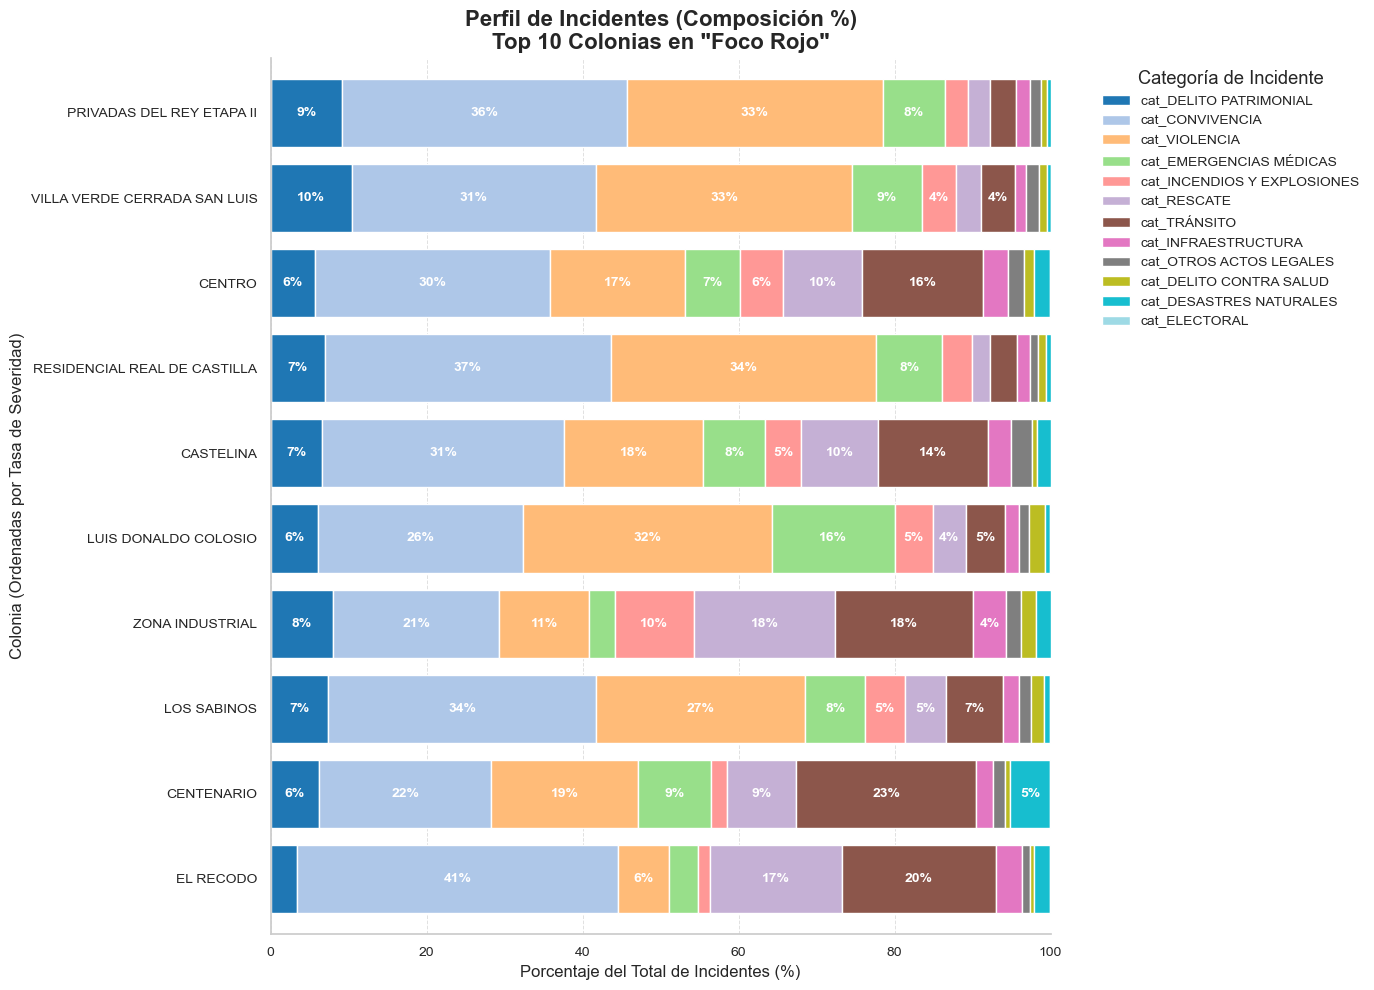

In [40]:
# --- 1. Validar que tenemos los DataFrames necesarios ---
try:
    df_focos_rojos_reporte
    df_limpio
except NameError as e:
    print(f"Error: No se encontró un DataFrame necesario: {e}")
    raise

# --- 2. Obtener la lista del Top 10 ---
top_10_foco_rojo_colonias = df_focos_rojos_reporte.head(10)['COLONIA'].tolist()


# --- 3. Identificar columnas de categoría y filtrar ---
cat_cols = [col for col in df_limpio.columns if col.startswith('cat_')]

if not cat_cols:
    print("Error: No se encontraron columnas de categoría (ej. 'cat_VIOLENCIA') en 'df_limpio'.")
else:
    cols_para_perfil = ['COLONIA', 'total_incidentes'] + cat_cols
    df_perfil = df_limpio[df_limpio['COLONIA'].isin(top_10_foco_rojo_colonias)][cols_para_perfil].copy()

    # --- 4. Calcular Porcentajes ---
    df_perfil_pct = df_perfil[cat_cols].div(df_perfil['total_incidentes'], axis=0) * 100
    df_perfil_pct = df_perfil_pct.replace([np.inf, -np.inf, np.nan], 0)
    df_perfil_pct['COLONIA'] = df_perfil['COLONIA']
    df_perfil_pct = df_perfil_pct.set_index('COLONIA')
    
    # --- 5. Ordenar el gráfico ---
    df_perfil_pct = df_perfil_pct.reindex(top_10_foco_rojo_colonias)

    # --- 6. Graficar ---
    cmap = plt.get_cmap('tab20') 
    ax = df_perfil_pct[cat_cols].plot(
        kind='barh', 
        stacked=True, 
        figsize=(14, 10), 
        cmap=cmap,
        width=0.8 
    )

    # --- 7. Agregar Etiquetas de Porcentaje ---
    
    # Define un umbral: no etiquetar rebanadas menores a este %
    label_threshold = 4  # Ajusta este 4% si quieres ver más o menos etiquetas

    for container in ax.containers:
        # Generar etiquetas: solo muestra si el valor es > umbral
        # 'w' es el ancho (el valor del porcentaje)
        labels = [f'{w:.0f}%' if w > label_threshold else '' for w in container.datavalues]
        
        # Usar la función bar_label para ponerlas
        ax.bar_label(
            container,
            labels=labels,
            label_type='center', 
            color='white',       
            fontweight='bold',
            fontsize=10           
        )


    # --- 8. Estilo y Limpieza ---
    ax.set_title('Perfil de Incidentes (Composición %)\nTop 10 Colonias en "Foco Rojo"', fontsize=16, fontweight='bold')
    ax.set_xlabel('Porcentaje del Total de Incidentes (%)', fontsize=12)
    ax.set_ylabel('Colonia (Ordenadas por Tasa de Severidad)', fontsize=12)
    
    ax.legend(title='Categoría de Incidente', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, 100)
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout() 
    plt.show()

Composición de incidentes para PARQUE INDUSTRIAL:
cat_CONVIVENCIA                4330
cat_TRÁNSITO                   2718
cat_RESCATE                    2665
cat_VIOLENCIA                  2578
cat_INCENDIOS Y EXPLOSIONES    1507
cat_DELITO PATRIMONIAL         1424
cat_EMERGENCIAS MÉDICAS        1093
cat_INFRAESTRUCTURA             702
cat_OTROS ACTOS LEGALES         465
cat_DESASTRES NATURALES         339
cat_DELITO CONTRA SALUD         246
cat_ELECTORAL                     3
Name: 349, dtype: int64


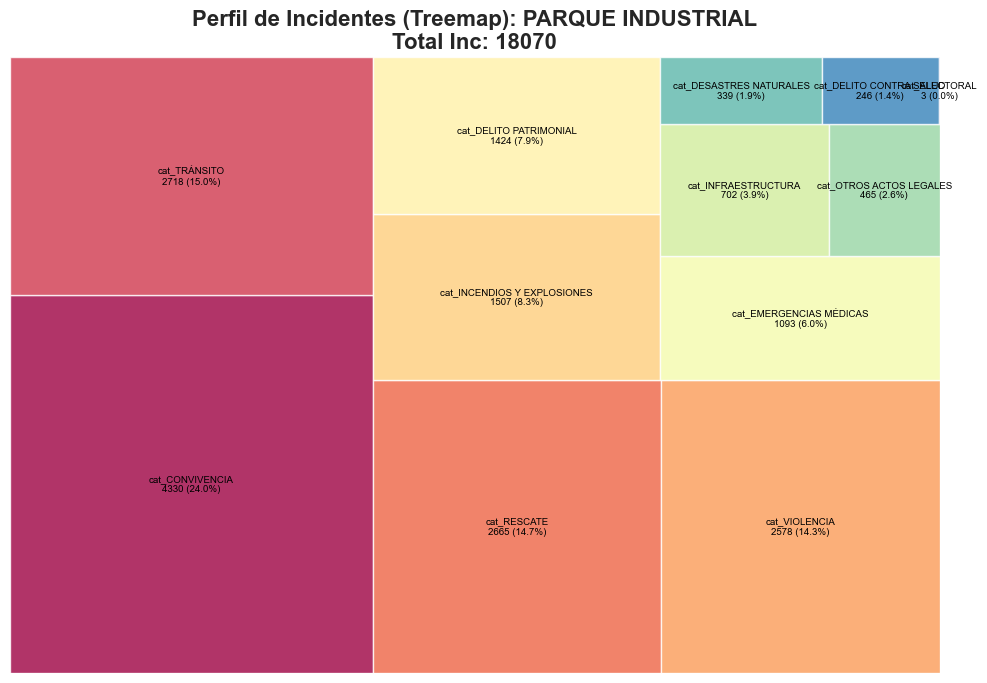

In [41]:
# --- 1. Definir la colonia a perfilar ---
colonia_a_perfilar = 'PARQUE INDUSTRIAL'

# --- 2. Validar que tenemos los datos ---
try:
    df_limpio
except NameError as e:
    print(f"Error: No se encontró el DataFrame 'df_limpio': {e}")
    raise

cat_cols = [col for col in df_limpio.columns if col.startswith('cat_')]

if not cat_cols:
    print("Error: No se encontraron columnas de categoría (ej. 'cat_VIOLENCIA') en 'df_limpio'.")
else:
    # --- 3. Extraer la fila de datos ---
    df_perfil = df_limpio[df_limpio['COLONIA'] == colonia_a_perfilar]
    
    if df_perfil.empty:
        print(f"Error: No se encontró la colonia '{colonia_a_perfilar}' en 'df_limpio'.")
    else:
        perfil_serie = df_perfil[cat_cols].iloc[0]
        
        # --- 4. Limpiar la Serie para el gráfico ---
        # Quitar categorías con 0 incidentes
        perfil_serie_filtrado = perfil_serie[perfil_serie > 0].sort_values(ascending=False)
        
        if perfil_serie_filtrado.empty:
            print(f"La colonia '{colonia_a_perfilar}' tiene 0 incidentes en todas las categorías.")
        else:
            print(f"Composición de incidentes para {colonia_a_perfilar}:")
            print(perfil_serie_filtrado)
            
            total_incidentes = perfil_serie_filtrado.sum()
            
            # --- 5. Crear Etiquetas para el Treemap ---
            # Ej: "cat_VIOLENCIA\n10 (33.3%)"
            labels = [
                f"{idx}\n{val} ({val/total_incidentes*100:.1f}%)"
                for idx, val in perfil_serie_filtrado.items()
            ]
            
            # --- 6. Graficar el Treemap ---
            plt.figure(figsize=(12, 8))
            
            # Usar un mapa de color
            cmap = plt.get_cmap('Spectral') # Un mapa de color diferente
            colors = cmap(np.linspace(0, 1, len(perfil_serie_filtrado)))
            
            squarify.plot(
                sizes=perfil_serie_filtrado.values,
                label=labels,
                color=colors,
                alpha=0.8,
                text_kwargs={'color': 'black', 'fontsize': 7}
            )
            
            plt.title(f'Perfil de Incidentes (Treemap): {colonia_a_perfilar}\nTotal Inc: {total_incidentes}', 
                      fontsize=16, fontweight='bold')
            plt.axis('off') # Ocultar los ejes
            plt.show()

# 5. Reducción de características para visualización (PCA)


ANÁLISIS DE COMPONENTES PRINCIPALES (PCA) 

>>> ANÁLISIS EXITOSO <<<
Varianza explicada por componente:
  PC1: 71.12%
  PC2: 6.38%
  PC3: 6.23%
  PC4: 4.33%
  PC5: 2.89%

* Para explicar el 95% de la varianza se necesitan 7 componentes
  - Columnas originales útiles: 41
  - Columnas eliminadas (vacías): 0


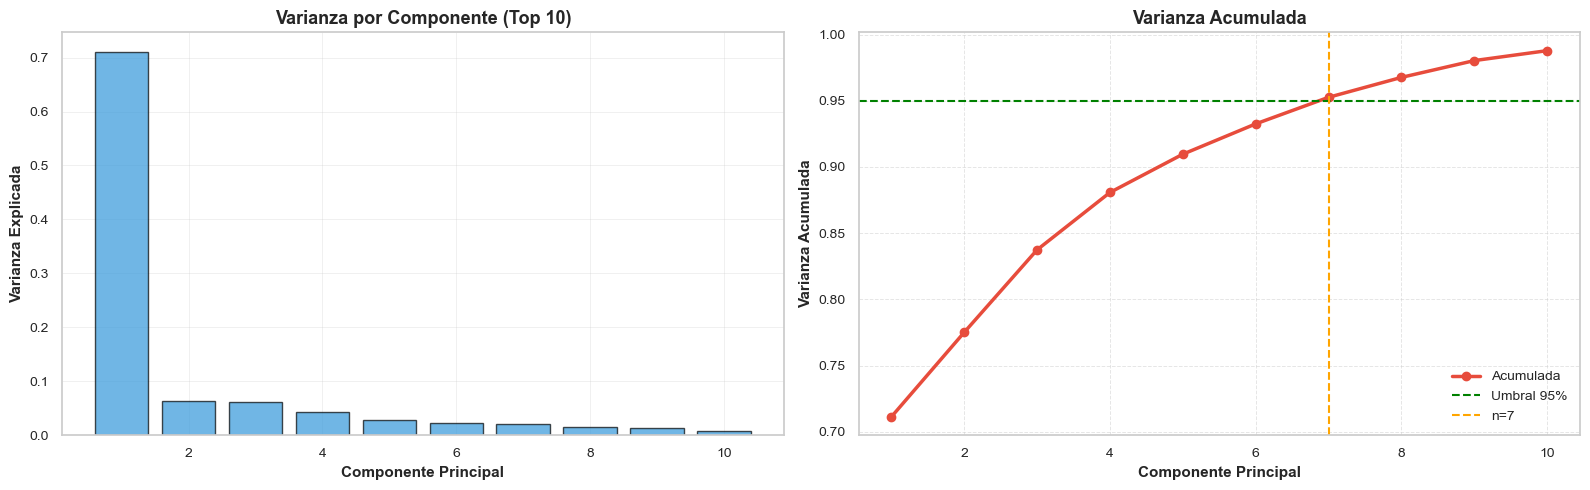

In [51]:
print("\n" + "="*70)
print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA) ")
print("="*70)


# 5. Aplicar PCA
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# 6. Calcular Varianza Explicada
cumsum_var = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"\n>>> ANÁLISIS EXITOSO <<<")
print(f"Varianza explicada por componente:")
for i in range(min(5, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.2%}")

print(f"\n* Para explicar el 95% de la varianza se necesitan {n_components_95} componentes")
print(f"  - Columnas originales útiles: {df_numeric.shape[1]}")
print(f"  - Columnas eliminadas (vacías): {len(numeric_cols) - df_numeric.shape[1]}")

# 7. Gráfico
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Varianza individual
axes[0].bar(range(1, len(pca.explained_variance_ratio_[:10])+1), 
            pca.explained_variance_ratio_[:10], alpha=0.7, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Componente Principal', fontweight='bold')
axes[0].set_ylabel('Varianza Explicada', fontweight='bold')
axes[0].set_title('Varianza por Componente (Top 10)', fontweight='bold')

# Varianza acumulada
axes[1].plot(range(1, len(cumsum_var[:10])+1), cumsum_var[:10], 
             marker='o', color='#e74c3c', linewidth=2.5, label='Acumulada')
axes[1].axhline(y=0.95, color='green', linestyle='--', label='Umbral 95%')
axes[1].axvline(x=n_components_95, color='orange', linestyle='--', label=f'n={n_components_95}')
axes[1].set_xlabel('Componente Principal', fontweight='bold')
axes[1].set_ylabel('Varianza Acumulada', fontweight='bold')
axes[1].set_title('Varianza Acumulada', fontweight='bold')
axes[1].legend()
axes[1].grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Resultado del Análisis de Componentes Principales (PCA)

###  Objetivo
El objetivo de esta sección fue reducir la complejidad del dataset (41 variables numéricas) eliminando la redundancia, pero conservando la información crítica para el análisis delictivo.

###  Hallazgos Principales
El algoritmo de PCA arrojó resultados muy positivos para la simplificación del modelo:

1.  **Reducción de Dimensionalidad:**
    * Se logró comprimir el dataset de **41 columnas originales** a solo **7 componentes principales**.
    * Esto representa una **reducción del 82%** en la complejidad de los datos.

2.  **Calidad de la Información (Varianza):**
    * Con estos 7 componentes, retenemos el **95% de la información original**.
    * El **Primer Componente (PC1)** por sí solo explica el **71.2%** de la varianza. Esto sugiere que existe un factor dominante (probablemente relacionado con la *magnitud* de la colonia: tamaño, población y cantidad total de incidentes)
    * El **Segundo Componente (PC2)** añade un **6.38%** de explicación, capturando matices adicionales (posiblemente el *tipo* o severidad del crimen).

###  Conclusión Técnica
El dataset presenta una alta correlación entre sus variables, lo que permitió una compresión eficiente. Para futuros modelos de **Machine Learning** (como Clustering o Predicción), se recomienda utilizar estos **7 componentes** en lugar de las 41 variables originales, lo que mejorará la velocidad de procesamiento y reducirá el riesgo de sobreajuste (*overfitting*).

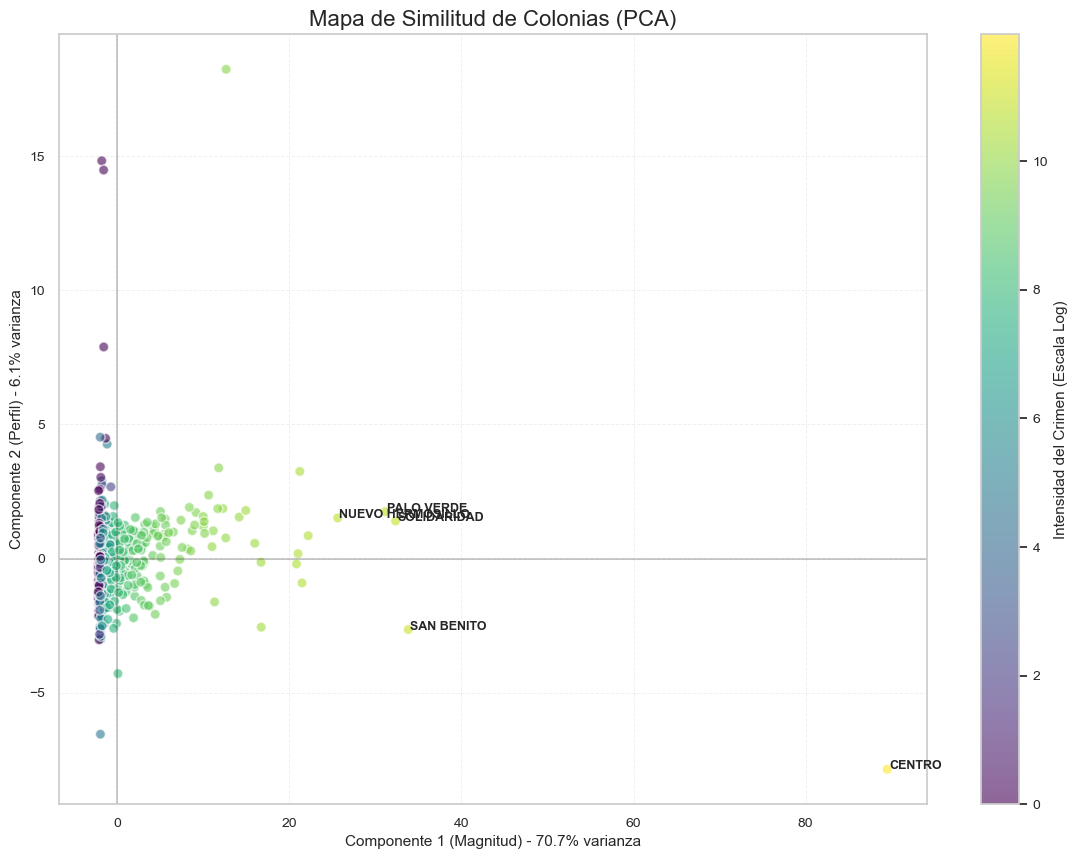

In [60]:
#Visualizacion PCA - Mapa de Similitud de Colonias
numeric_cols = df_limpio.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df_limpio[numeric_cols].dropna(axis=1, how='all') # Borrar col vacía
df_numeric_filled = df_numeric.fillna(df_numeric.mean()) # Rellenar huecos

# 2. Aplicar PCA (Reducir a 2 dimensiones)
# -------------------------------------------------------
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric_filled)

pca = PCA(n_components=2)
coords_pca = pca.fit_transform(df_scaled)

# Crear un DataFrame temporal para graficar
df_pca_vis = pd.DataFrame(data=coords_pca, columns=['PC1', 'PC2'])
df_pca_vis['COLONIA'] = df['COLONIA']
df_pca_vis['Crimen_Total'] = df['total_incidentes']

# 3. Generar la Visualización
# -------------------------------------------------------
plt.figure(figsize=(14, 10))

# Dibujar los puntos
# Usamos logaritmo en el color (np.log1p) para que el "Centro" no apague a los demás
scatter = plt.scatter(x=df_pca_vis['PC1'], 
                      y=df_pca_vis['PC2'], 
                      c=np.log1p(df_pca_vis['Crimen_Total']), 
                      cmap='viridis', 
                      alpha=0.6, 
                      s=50, 
                      edgecolors='w')

# Añadir nombres a los "Outliers" (Puntos extremos a la derecha)
# Esto ayuda a entender quién es quién en el mapa
extremos = df_pca_vis.nlargest(5, 'PC1')
for i, row in extremos.iterrows():
    plt.text(row['PC1']+0.2, row['PC2'], row['COLONIA'], fontsize=9, fontweight='bold')

# Decoración
plt.colorbar(scatter, label='Intensidad del Crimen (Escala Log)')
plt.title('Mapa de Similitud de Colonias (PCA)', fontsize=16)
plt.xlabel(f'Componente 1 (Magnitud) - {pca.explained_variance_ratio_[0]:.1%} varianza')
plt.ylabel(f'Componente 2 (Perfil) - {pca.explained_variance_ratio_[1]:.1%} varianza')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axvline(0, color='black', alpha=0.2)
plt.axhline(0, color='black', alpha=0.2)

plt.show()

### 5.2 Análisis de Cargas: Relación entre Variables y Componentes

Interpretación de cómo las variables originales se proyectan en el espacio de componentes principales.

In [63]:
print("\nCorrelaciones entre variables originales y componentes principales:")
print("-" * 70)

# 1. IMPORTANTE: Volvemos a ajustar el PCA completo (sin límite de 2 componentes)
# para poder analizar más allá del PC1 y PC2.
pca = PCA()
pca.fit(df_scaled) # Usamos df_scaled que ya creaste antes

# 2. Calcular Cargas (Loadings)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# 3. Crear la tabla (Matriz)
# Automáticamente detectamos cuántos componentes mostrar (máximo 5)
n_components_to_show = min(5, len(pca.components_))

loading_matrix = pd.DataFrame(
    loadings[:, :n_components_to_show],
    columns=[f'PC{i+1}' for i in range(n_components_to_show)],
    index=df_numeric.columns # Usamos las columnas limpias (19 variables)
)

print(loading_matrix.to_string())

print("\n* Interpretación de cargas:")
print("  - Valores altos (cercanos a ±1): Variable fuertemente relacionada con el componente")
print("  - Valores bajos (cercanos a 0): Poca relación con el componente")
print("  - Signo: Dirección de la relación (positiva o negativa)")

# 4. Mostrar principales aportes a PC1 y PC2
cols_to_show = ['PC1', 'PC2']

for col in cols_to_show:
    print(f"\nTop 3 variables que definen al {col}:")
    # Ordenamos por valor absoluto
    top_vars = loading_matrix[col].abs().sort_values(ascending=False).head(3)
    
    for var, val in top_vars.items():
        # Recuperamos el valor real para ver el signo
        real_val = loading_matrix.loc[var, col]
        print(f"  • {var}: {real_val:.3f}")


Correlaciones entre variables originales y componentes principales:
----------------------------------------------------------------------
                                  PC1       PC2       PC3       PC4       PC5
total_incidentes             0.997867 -0.032131 -0.019437 -0.053591  0.022958
incidentes_alta              0.988257  0.021869 -0.051301  0.055372  0.018243
incidentes_media             0.984776 -0.066929  0.017329 -0.136861  0.015551
incidentes_baja              0.987119 -0.041445 -0.040274 -0.050304  0.040928
incidentes_fin_semana        0.995080 -0.005025 -0.041098  0.016024  0.022382
poblacion_total              0.667411  0.178153 -0.145267  0.621409 -0.095452
viviendas_totales            0.696611  0.141100 -0.126308  0.580771 -0.110413
escolaridad_años_prom       -0.169885 -0.584538  0.336628 -0.108303 -0.285181
pctj_menores18              -0.110297  0.457349 -0.249650  0.039608  0.292929
pctj_hombres                 0.012158  0.782030 -0.386090 -0.365653 -0.208343
pc

## 6. Análisis de Variables Categóricas

Caracterización de variables nominales: cardinalidad, frecuencias y distribuciones.

In [72]:
print("\n" + "="*70)
print("ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*70)

categorical_cols = df_limpio.select_dtypes(include=['category']).columns.tolist()

print(f"\nVariables categóricas encontradas: {len(categorical_cols)}")
print(f"Columnas: {', '.join(categorical_cols[:5])}")

for col in categorical_cols[:5]:
    n_unique = df_limpio[col].nunique()
    top_value = df_limpio[col].value_counts().index[0]
    top_pct = (df_limpio[col].value_counts().values[0] / len(df_limpio)) * 100
    print(f"\n* {col}:")
    print(f"  - Valores únicos: {n_unique}")
    print(f"  - Valor más frecuente: {top_value} ({top_pct:.1f}%)")


ANÁLISIS DE VARIABLES CATEGÓRICAS

Variables categóricas encontradas: 3
Columnas: CVE_COL, COLONIA, CP

* CVE_COL:
  - Valores únicos: 700
  - Valor más frecuente: 2603000016832 (0.1%)

* COLONIA:
  - Valores únicos: 700
  - Valor más frecuente: ZONA INDUSTRIAL (0.1%)

* CP:
  - Valores únicos: 96
  - Valor más frecuente: 83170.0 (9.6%)


In [75]:
print("\n" + "-"*70)
print("Distribución de principales variables categóricas:")
print("-"*70)

for col in categorical_cols[:3]:
    print(f"\n{col}:")
    value_counts = df_limpio[col].value_counts()
    for idx, (val, count) in enumerate(value_counts.head(5).items(), 1):
        pct = (count / len(df_limpio)) * 100
        bar = "*" * int(pct / 2)
        print(f"  {idx}. {val}: {count:,} ({pct:.1f}%) {bar}")
    
    if len(value_counts) > 5:
        others = value_counts[5:].sum()
        pct = (others / len(df_limpio)) * 100
        print(f"  ... y {len(value_counts) - 5} más: {others:,} ({pct:.1f}%)")



----------------------------------------------------------------------
Distribución de principales variables categóricas:
----------------------------------------------------------------------

CVE_COL:
  1. 2603000016832: 1 (0.1%) 
  2. 2603000010: 1 (0.1%) 
  3. 2603000011343: 1 (0.1%) 
  4. 2603000011346: 1 (0.1%) 
  5. 2603000011347: 1 (0.1%) 
  ... y 695 más: 695 (99.3%)

COLONIA:
  1. ZONA INDUSTRIAL: 1 (0.1%) 
  2. 14 DE MARZO: 1 (0.1%) 
  3. 4 DE MARZO: 1 (0.1%) 
  4. 4TA ZONA MILITAR: 1 (0.1%) 
  5. ACACIAS RESIDENCIAL: 1 (0.1%) 
  ... y 695 más: 695 (99.3%)

CP:
  1. 83170.0: 67 (9.6%) ****
  2. 83240.0: 52 (7.4%) ***
  3. 83104.0: 45 (6.4%) ***
  4. 83105.0: 38 (5.4%) **
  5. 83118.0: 37 (5.3%) **
  ... y 91 más: 461 (65.9%)


## 7. Análisis de correlación entre variables

In [77]:
print("="*70)
print("ANÁLISIS DE RELACIONES ENTRE VARIABLES")
print("="*70)


print("\nCorrelaciones entre variables originales y componentes principales:")
print("-" * 70)

# Crear pair plot
print(f"\nGenerando Pair Plot (análisis de relaciones)...")

ANÁLISIS DE RELACIONES ENTRE VARIABLES

Columnas numéricas seleccionadas para análisis:
  • total_incidentes
  • incidentes_alta
  • incidentes_media
  • incidentes_baja
  • incidentes_fin_semana
  • poblacion_total
  • viviendas_totales
  • escolaridad_años_prom

Generando Pair Plot (análisis de relaciones)...


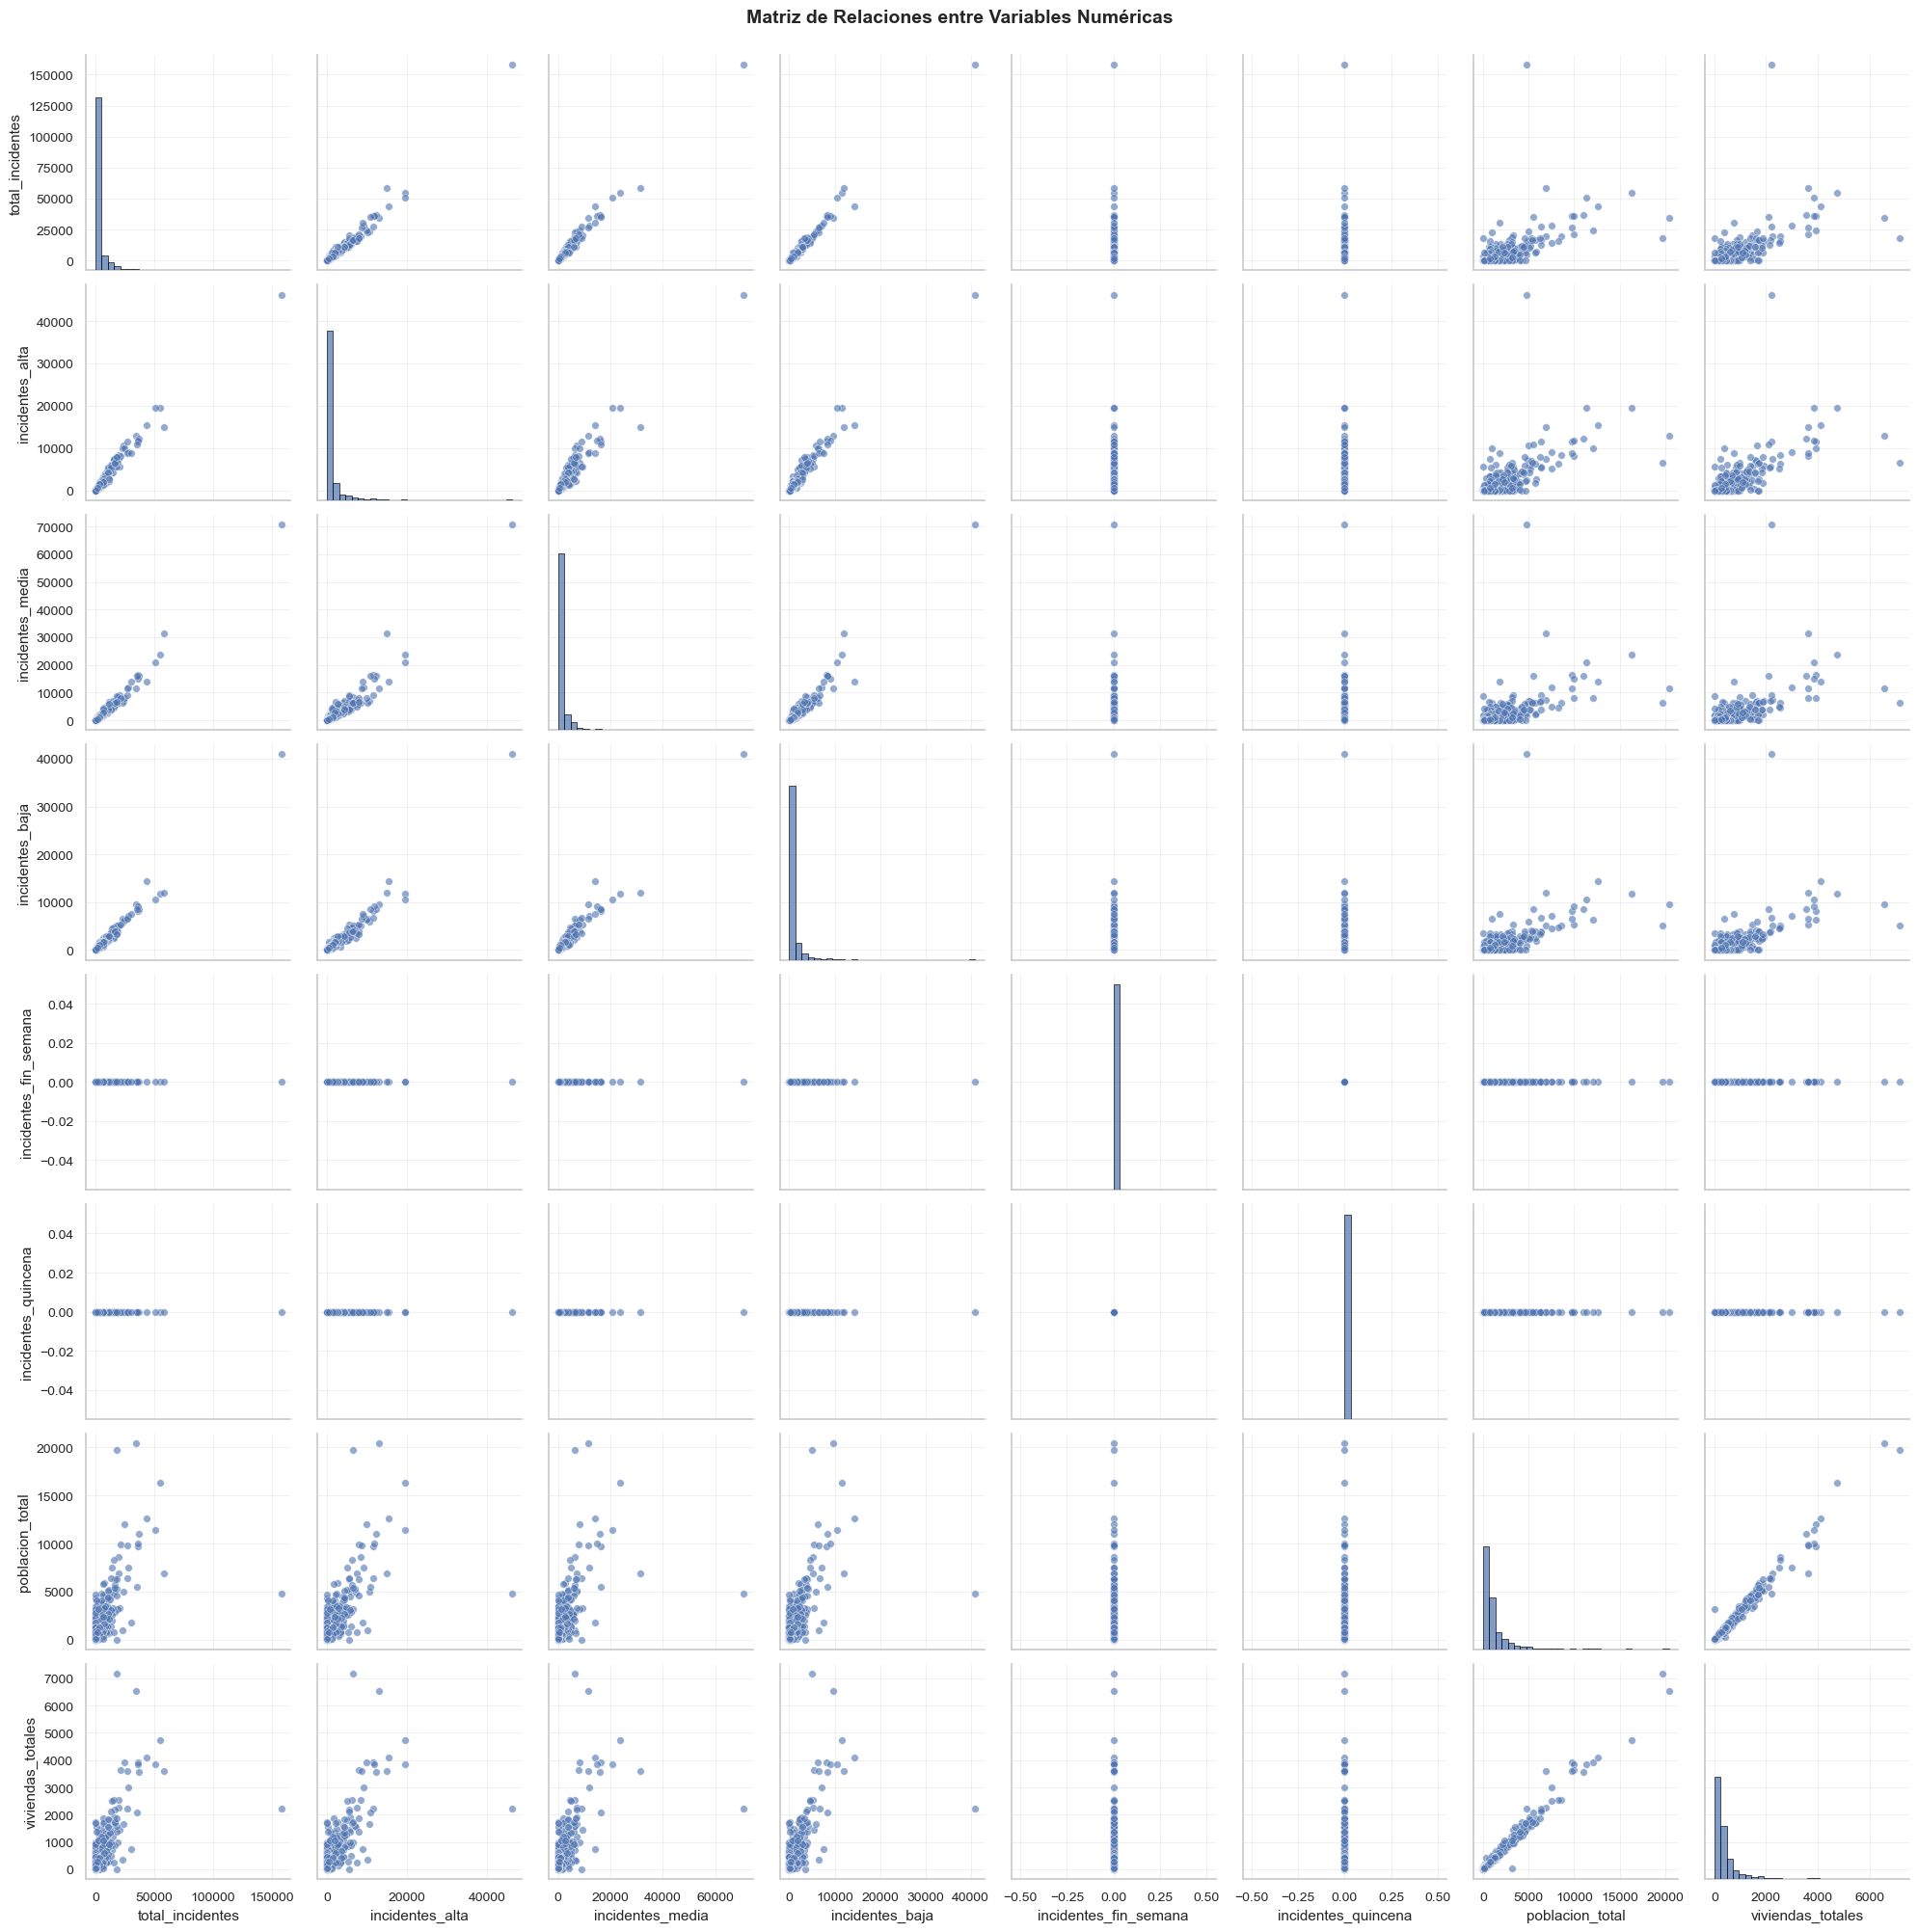


Pair Plot generado: Muestra relaciones bivariadas entre variables


In [147]:
# Pair plot
if len(key_numeric_cols) >= 2:
    df_subset = df_limpio[key_numeric_cols].fillna(df_limpio[key_numeric_cols].mean())
    
    # Usar seaborn pairplot
    pairplot = sns.pairplot(df_subset, diag_kind='hist', plot_kws={'alpha': 0.6, 's': 30},
                           diag_kws={'bins': 30, 'edgecolor': 'black', 'alpha': 0.7})
    pairplot.fig.suptitle('Matriz de Relaciones entre Variables Numéricas', 
                          fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    print(f"\nPair Plot generado: Muestra relaciones bivariadas entre variables")

In [78]:
print("\n" + "="*70)
print("ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*70)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nVariables categóricas encontradas: {len(categorical_cols)}")
print(f"Columnas: {', '.join(categorical_cols[:5])}")

for col in categorical_cols[:5]:
    n_unique = df[col].nunique()
    top_value = df[col].value_counts().index[0]
    top_pct = (df[col].value_counts().values[0] / len(df)) * 100
    print(f"\n* {col}:")
    print(f"  - Valores únicos: {n_unique}")
    print(f"  - Valor más frecuente: {top_value} ({top_pct:.1f}%)")


ANÁLISIS DE VARIABLES CATEGÓRICAS

Matriz de correlación calculada: (39, 39)
Rango de correlaciones: [-1.000, 1.000]


In [79]:
print("\n" + "-"*70)
print("Distribución de principales variables categóricas:")
print("-"*70)

for col in categorical_cols[:3]:
    print(f"\n{col}:")
    value_counts = df[col].value_counts()
    for idx, (val, count) in enumerate(value_counts.head(5).items(), 1):
        pct = (count / len(df)) * 100
        bar = "*" * int(pct / 2)
        print(f"  {idx}. {val}: {count:,} ({pct:.1f}%) {bar}")
    
    if len(value_counts) > 5:
        others = value_counts[5:].sum()
        pct = (others / len(df)) * 100
        print(f"  ... y {len(value_counts) - 5} más: {others:,} ({pct:.1f}%)")

if len(strong_corr) > 0:
    strong_corr_df = pd.DataFrame(strong_corr).sort_values('Correlación', key=abs, ascending=False)
    print(strong_corr_df.to_string(index=False))
else:
    print("No se encontraron correlaciones fuertes (|r| > 0.7)")

print(f"\nCORRELACIONES MODERADAS (0.5 < |r| <= 0.7):")
print("-" * 70)

moderate_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if 0.5 < abs(corr_val) <= 0.7:
            moderate_corr.append({
                'Variable1': correlation_matrix.columns[i],
                'Variable2': correlation_matrix.columns[j],
                'Correlación': corr_val
            })

if len(moderate_corr) > 0:
    moderate_corr_df = pd.DataFrame(moderate_corr).sort_values('Correlación', key=abs, ascending=False)
    print(moderate_corr_df.head(10).to_string(index=False))
    if len(moderate_corr_df) > 10:
        print(f"... y {len(moderate_corr_df) - 10} más")
else:
    print("No se encontraron correlaciones moderadas (0.5 < |r| <= 0.7)")


----------------------------------------------------------------------
                  Variable1                   Variable2  Correlación
               pctj_hombres                pctj_mujeres    -1.000000
     tasa_incidentes_per_1k  tasa_alta_severidad_per_1k     0.999850
           total_incidentes                   dia_Lunes     0.999779
              dia_Miércoles                  dia_Jueves     0.999676
                 dia_Martes                  dia_Jueves     0.999654
                 dia_Martes               dia_Miércoles     0.999606
                dia_Viernes                  dia_Jueves     0.999590
                 dia_Martes                 dia_Viernes     0.999538
                dia_Viernes               dia_Miércoles     0.999365
           total_incidentes                  dia_Sábado     0.998919
      incidentes_fin_semana              partedia_Noche     0.998700
                  dia_Lunes               dia_Miércoles     0.998221
                 dia_Sábado    

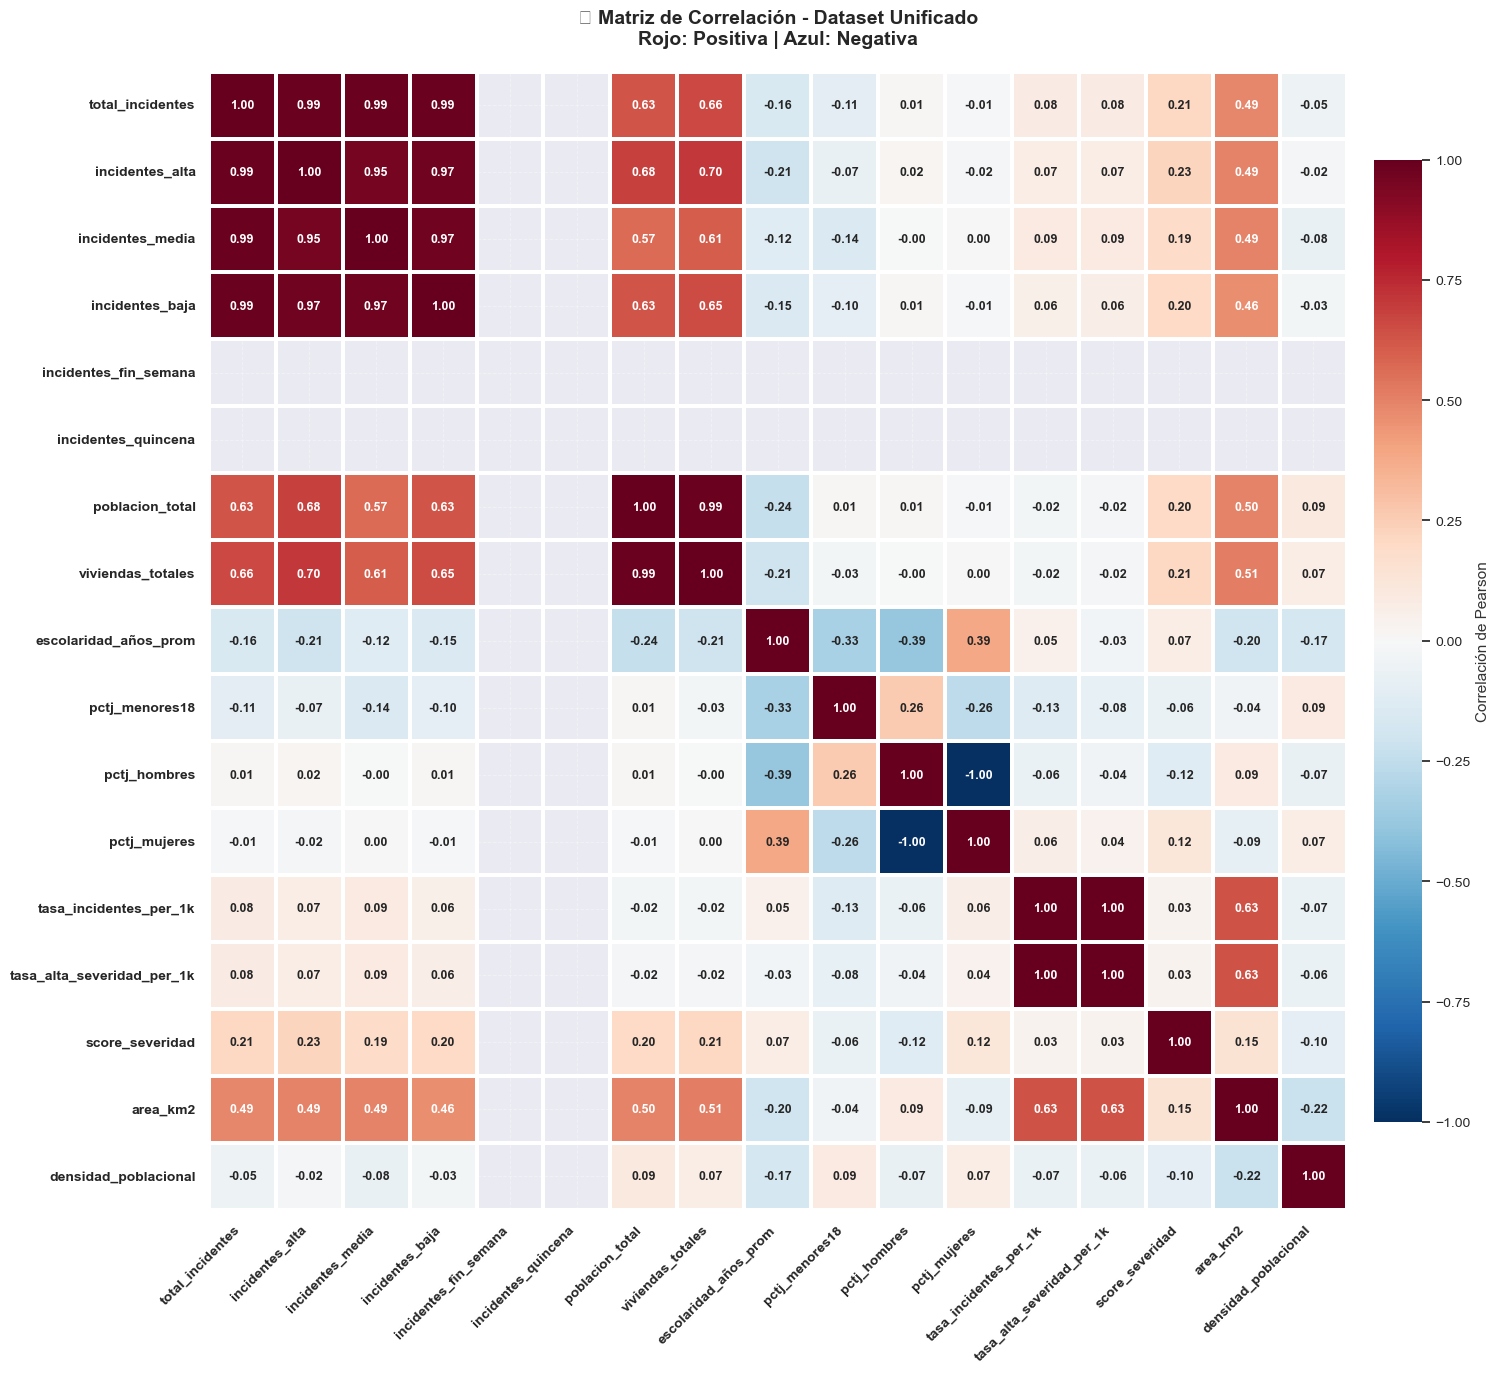


✓ Heatmap: Matriz de correlación entre todas las variables numéricas
  Rojo = Correlación positiva fuerte | Azul = Correlación negativa fuerte


In [ ]:
# Heatmap de correlación 
fig, ax = plt.subplots(figsize=(16, 14))

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1.5, linecolor='white',
            cbar_kws={'label': 'Correlación de Pearson', 'shrink': 0.8, 'pad': 0.02},
            ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 9, 'weight': 'bold'},
            xticklabels=True, yticklabels=True)

ax.set_title(' Matriz de Correlación - Dataset Unificado\nRojo: Positiva | Azul: Negativa', 
             fontweight='bold', fontsize=14, pad=20)

# Mejorar labels
plt.xticks(rotation=45, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nHeatmap: Matriz de correlación entre todas las variables numéricas")
print(f"  Rojo = Correlación positiva fuerte | Azul = Correlación negativa fuerte")

### Interpretación de la matriz de correlación (Valores $|r| > 0.7$)

El análisis de correlación de Pearson se realizó para identificar la relación lineal entre las variables numéricas del conjunto de datos. Un valor cercano a 1 o -1 indica una correlación lineal perfecta.

Los resultados de la matriz, específicamente las correlaciones con un valor absoluto superior a 0.7, no revelan patrones de comportamiento social, sino que exponen problemas severos de **multicolinealidad** y **fuga de datos (data leakage)**.

Estos hallazgos son fundamentalmente un diagnóstico para la limpieza de datos antes de cualquier modelado.

#### 1. Correlaciones de redundancia

* **`pctj_hombres` vs. `pctj_mujeres` ($r = -1.000$)**:
    Esta es una correlación matemáticamente obvia, no un hallazgo. Ambas variables miden el mismo concepto desde ángulos opuestos. Si una sube, la otra debe bajar en proporción.

#### 2. Fuga de Datos

* **`total_incidentes` vs. `dia_Sábado` ($r = 0.998$)**:
    Se observa una correlación casi perfecta entre el total de incidentes y las columnas individuales de días (`dia_Lunes`, `dia_Martes`, etc.). Esto indica que la variable `total_incidentes` es la suma de estas columnas.
* **Impacto:** Usar estas variables juntas en un modelo predictivo constituiría una "fuga de datos" (data leakage), ya que le estaríamos dando al modelo la respuesta por adelantado.

#### 3. Multicolinealidad severa

* **`dia_Miércoles` vs. `dia_Jueves` ($r = 0.999$)**:
    Todas las variables de conteo de incidentes por día (`dia_Lunes`, `dia_Martes`...) y por parte del día (`partedia_Noche`...) están casi perfectamente correlacionadas entre sí.
* **Interpretación Real:** Esto **no** significa que los incidentes del lunes causen los del martes. Significa que las colonias se dividen en dos grupos: "colonias de alta incidencia" (que tienen muchos incidentes todos los días) y colonias de baja incidencia (que tienen pocos incidentes todos los días). No existe un perfil de colonia que sea peligroso solo los lunes pero seguro los sábados; el patrón de riesgo es constante.


#### 4. Correlación de métricas derivadas

* **`tasa_incidentes_per_1k` vs. `tasa_alta_severidad_per_1k` ($r = 0.999$)**:
    Estas dos métricas de tasa son prácticamente iguales. Esto sugiere que la `tasa_alta_severidad` es el componente principal que "mueve" la `tasa_incidentes_per_1k` total. En la práctica, son la misma variable.

---

### Conclusión

El informe de correlación es una herramienta de **diagnóstico** que nos obliga a realizar una **selección de características (feature selection)** estricta antes del modelado.

Si se incluyeran estas variables redundantes en un modelo los resultados serían inestables y no interpretables.

**Acción inmediata:** Se debe crear un nuevo conjunto de datos para el modelado que elimine estas redundancias.

Columnas originales: 44
Columnas para modelo: 15

Columnas seleccionadas: ['COLONIA', 'CP', 'poblacion_total', 'viviendas_totales', 'escolaridad_años_prom', 'pctj_menores18', 'pctj_hombres', 'tasa_alta_severidad_per_1k', 'score_severidad', 'area_km2', 'densidad_poblacional', 'incidentes_fin_semana', 'incidentes_alta', 'incidentes_media', 'incidentes_baja']


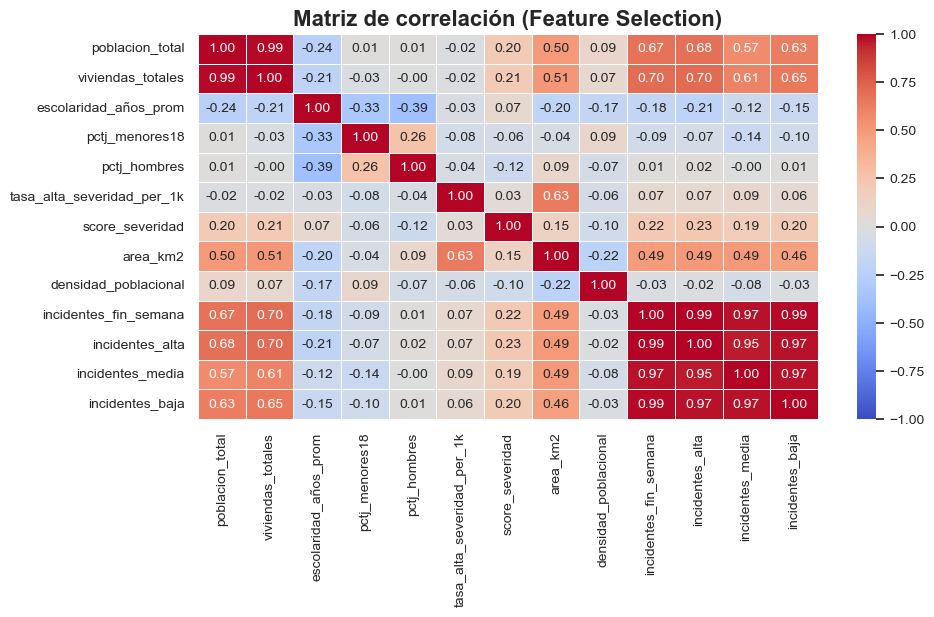

In [80]:
# --- 1. Definimos características seleccionadas ---

columnas_para_modelo = [
    # --- Identificadores (no para el modelo, pero sí para el análisis) ---
    'COLONIA', 
    'CP',
    
    # --- Demografía (¡Oro puro!) ---
    'poblacion_total',
    'viviendas_totales',
    'escolaridad_años_prom',
    'pctj_menores18',
    'pctj_hombres', # (Quitamos 'pctj_mujeres' por ser -1.0)
    
    # --- Métricas de Riesgo (¡La clave!) ---
    # (Quitamos 'tasa_incidentes_per_1k' por ser 0.999 con esta)
    'tasa_alta_severidad_per_1k', 
    'score_severidad', 
    
    # --- Métricas Físicas ---
    'area_km2',
    'densidad_poblacional',

    # --- Resúmenes de Tiempo (¡Mejor que los días individuales!) ---
    # (Quitamos todos los 'dia_Lunes', 'partedia_Noche', etc.)
    'incidentes_fin_semana',
    
    # Conteo de delitos por severidad
    'incidentes_alta', 
    'incidentes_media', 
    'incidentes_baja',
    
    
    # --- El Target (lo que quieres predecir, o tus scores) ---
    'anomaly_isolation_forest', 
    'anomaly_score'
]

# Verifica que todas las columnas existan en el DataFrame
columnas_existentes = [col for col in columnas_para_modelo if col in df_limpio.columns]

# --- 2. Crea el nuevo DataFrame ---
df_modelo = df_limpio[columnas_existentes].copy()

print(f"Columnas originales: {len(df_limpio.columns)}")
print(f"Columnas para modelo: {len(df_modelo.columns)}")
print(f"\nColumnas seleccionadas: {list(df_modelo.columns)}")

# --- 3. Matriz de correlación LIMPIA (solo features reales) ---

corr_limpia = df_modelo.corr(numeric_only=True)

plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_limpia, 
    annot=True,        # Muestra los números
    cmap='coolwarm',   # Azul (negativo) a Rojo (positivo)
    fmt='.2f',         # Solo 2 decimales
    linewidths=.5,
    vmin=-1, vmax=1     # Fija la escala de -1 a 1
)
plt.title('Matriz de correlación (Feature Selection)', fontsize=16, fontweight='bold')
plt.show()

### 1. Multicolinealidad remanente


**Multicolinealidad demográfico (0.99)**
* `poblacion_total` vs. `viviendas_totales` = **0.99**
* **Interpretación:** Las colonias con más gente tienen más casas. Es la misma información dicha de dos formas.

**Multicolinealidad incidentes (0.95 - 0.99)**
* `incidentes_fin_semana` vs. `incidentes_alta` = **0.99**
* `incidentes_fin_semana` vs. `incidentes_media` = **0.97**
* `incidentes_fin_semana` vs. `incidentes_baja` = **0.99**
* (`alta`, `media`, y `baja` están todas 0.95-0.97 entre ellas).

* **Interpretación:** Si una colonia tiene muchos incidentes los fines de semana (`incidentes_fin_semana`), esos incidentes se reparten de forma proporcional entre alta, media y baja severidad. No hay colonias únicamente de alta severidad o exclusivamente de baja severidad. Si una colonia es peligrosa, lo es en todas las categorías.
---

### 2. Hallazgos relevantes

**`score_severidad` es una medida apropiada para medir anomalías**
* `score_severidad` vs. `anomaly_score` = **-0.58**
* **Interpretación:** La correlación de -0.58 indica que `score_severidad` (que tú creaste) es un buen predictor de lo que el modelo `IsolationForest` considera una anomalía. (Es negativa porque un `anomaly_score` más bajo significa más anómalo).

**La Educación y la demografía importan**
* `escolaridad_años_prom` vs. `pctj_menores18` = **-0.33**
* **Interpretación:** En colonias con un mayor porcentaje de menores de 18 años, el promedio de escolaridad de la población total es más bajo. Esto es un *insight* demográfico real.
* `escolaridad_años_prom` vs. `pctj_hombres` = **-0.39**
* **Interpretación:** Las colonias con más hombres tienen (ligeramente) menor escolaridad promedio. Esto podría ser ruido, o un artefacto (quizás zonas industriales o laborales específicas).

---

### **Conclusión**

El dataframe aún requiere disminución de características.

Columnas finales para el modelo: 11


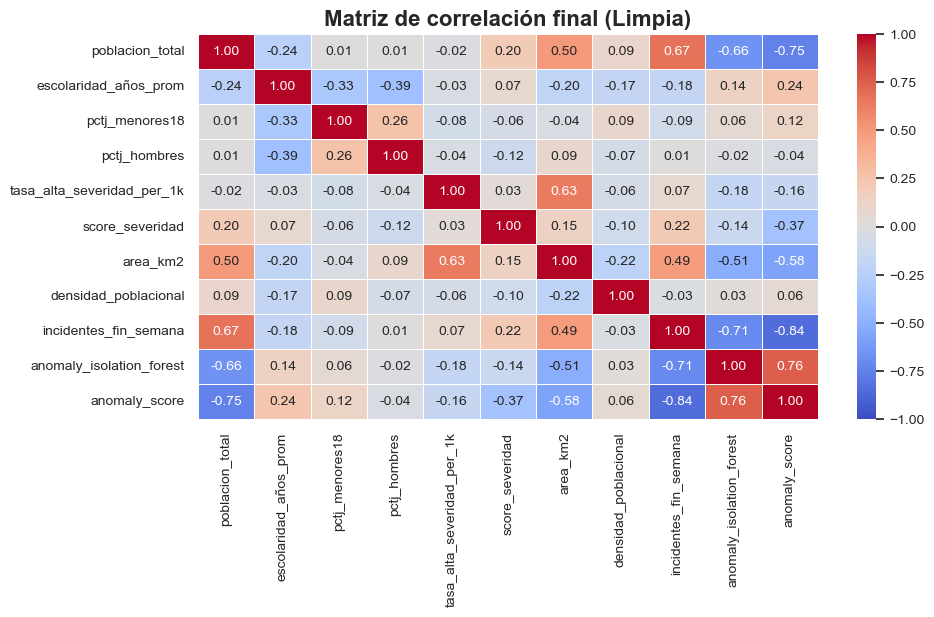

In [87]:
# --- 1. Definimos features relevantes ---

columnas_finales = [
    # --- Demografía (Sin 'viviendas_totales') ---
    'poblacion_total',
    'escolaridad_años_prom',
    'pctj_menores18',
    'pctj_hombres',
    
    # --- Métricas de riesgo (Ambas son únicas) ---
    'tasa_alta_severidad_per_1k', 
    'score_severidad', 
    
    # --- Métricas físicas ---
    'area_km2',
    'densidad_poblacional',

    # --- Resumen de tiempo (Sin 'alta', 'media', 'baja') ---
    'incidentes_fin_semana',
    
    # --- El target (scores) ---
    'anomaly_isolation_forest', 
    'anomaly_score'
]

columnas_existentes = [col for col in columnas_finales if col in df_limpio.columns]

# --- 2. Crea el DataFrame FINAL ---
df_modelo_FINAL = df_limpio[columnas_existentes].copy()

print(f"Columnas finales para el modelo: {len(df_modelo_FINAL.columns)}")

# --- 3. Creación de heatmap final ---

corr_final = df_modelo_FINAL.corr(numeric_only=True)

plt.figure(figsize=(10, 5))
sns.heatmap(
    corr_final, 
    annot=True,        
    cmap='coolwarm',   
    fmt='.2f',         
    linewidths=.5,
    vmin=-1, vmax=1    
)
plt.title('Matriz de correlación final (Limpia)', fontsize=16, fontweight='bold')
plt.show()

### Resumen de hallazgos: Matriz de correlación limpia

Tras un riguroso proceso de selección de características (feature selection) para eliminar la multicolinealidad, la matriz de correlación final revela la verdadera estructura de los datos. Ya no está contaminada por "ecos" (correlaciones de 0.99), y cada valor representa una historia real.

#### 1. Volumen de delitos vs. Riesgo

La limpieza de datos ha expuesto dos palancas completamente diferentes en nuestro conjunto de datos:

* **El volumen es impulsado por la población:**
    `incidentes_fin_semana` tiene una correlación alta con `poblacion_total` (**0.67**). Esto confirma nuestra hipótesis: las colonias con más gente tienen más incidentes. El *volumen* de incidentes es, en gran medida, una función del *tamaño* de la colonia.

* **El riesgo es independiente:**
    `tasa_alta_severidad_per_1k` (nuestra métrica de riesgo) no tiene correlación significativa con nada. Su correlación con `poblacion_total` es **-0.02** y con `incidentes_fin_semana` es **0.07**. Demostrando así que el riesgo (la tasa) es un problema completamente independiente del tamaño de la población. Esto valida el enfoque de nuestro gráfico de cuadrantes, que encontró colonias pequeñas y muy peligrosas, y colonias grandes y muy seguras.

#### 2. Escolaridad promedio vs. delitos

Históricamente, la densidad poblacional y el nivel educativo se consideran factores clave en el análisis del crimen. Nuestros datos demuestran lo contrario:

* **`densidad_poblacional` vs. `tasa_alta_severidad_per_1k` ($r = -0.06$)**: No existe **ninguna correlación** entre el hecho de que una colonia sea densa (mucha gente en poco espacio) y su tasa de incidentes graves.
* **`escolaridad_años_prom` vs. `tasa_alta_severidad_per_1k` ($r = -0.03$)**: Del mismo modo, el nivel educativo promedio de una colonia es un **predictor nulo**. No hay una relación lineal entre la escolaridad y el riesgo.

Este es un hallazgo crítico: ni la densidad ni la escolaridad nos sirven para predecir el riesgo de incidentes severos en una colonia.

#### 3. Geografía vs. severidad

Mientras los factores demográficos no mostraron una alta correlación, un factor geográfico emergió como el predictor más fuerte:

* **`area_km2` vs. `tasa_alta_severidad_per_1k` ($r = 0.63$)**: Esta es una correlación positiva y fuerte que parece indicar que el riesgo de incidentes graves no está ligado a cuánta gente vive en una colonia, sino a cuán grande y dispersa es esa colonia.

Este hallazgo sugiere que la **expansión urbana ** es un factor de riesgo clave.

**Hipótesis:** Las colonias que son físicamente enormes (con gran `area_km2`) son intrínsecamente más peligrosas. Se tiene la hipótesis de que probablemente esto se deba a que son más difíciles y costosas de patrullar, tienen tiempos de respuesta a emergencias más largos, la comunidad no es tan unida por lo que no se conocen entre habitantes y sufren de una menor vigilancia social natural (poco patrullaje de vecinos).

#### 4. El modelo

Las dos últimas filas de la matriz (`anomaly_score` y `anomaly_isolation_forest`) nos dicen qué es lo que el modelo de Machine Learning considera "raro":

* El `anomaly_score` tiene una correlación *masiva* con `incidentes_fin_semana` (**-0.84**) y `poblacion_total` (**-0.75**), pero tiene una correlación *casi nula* con la métrica de riesgo `tasa_alta_severidad_per_1k` (**-0.16**).

---

### **Conclusión :**

* Este análisis sugiere que la asignación de recursos y las estrategias de patrullaje no deben basarse en la densidad de población, sino en la **cobertura geográfica** de las colonias.

* El modelo IsolationForest **no es un "detector de riesgo"**. Le pedimos que encontrara "colonias raras" y encontró aquellas que son *outliers en volumen y población*.

* Prueba que el análisis humano (nuestro gráfico de cuadrantes) fue una herramienta mucho más inteligente para identificar el **riesgo real** que el modelo de anomalías, que fue distraído por el **volumen bruto**.

Hemos validado exitosamente que para entender el peligro, debemos ignorar el volumen total y centrarnos en la **tasa de severidad** y **geografía**.

### Correlaciones con Variable Objetivo

Análisis de relaciones bivariadas entre predictores y variable de interés (tasa de incidentes).


 CORRELACIONES CON VARIABLE OBJETIVO: tasa_alta_severidad_per_1k
----------------------------------------------------------------------
area_km2                    0.634187
incidentes_fin_semana       0.074185
score_severidad             0.032606
poblacion_total            -0.022970
escolaridad_años_prom      -0.034878
pctj_hombres               -0.043470
densidad_poblacional       -0.063672
pctj_menores18             -0.080946
anomaly_score              -0.161971
anomaly_isolation_forest   -0.176309


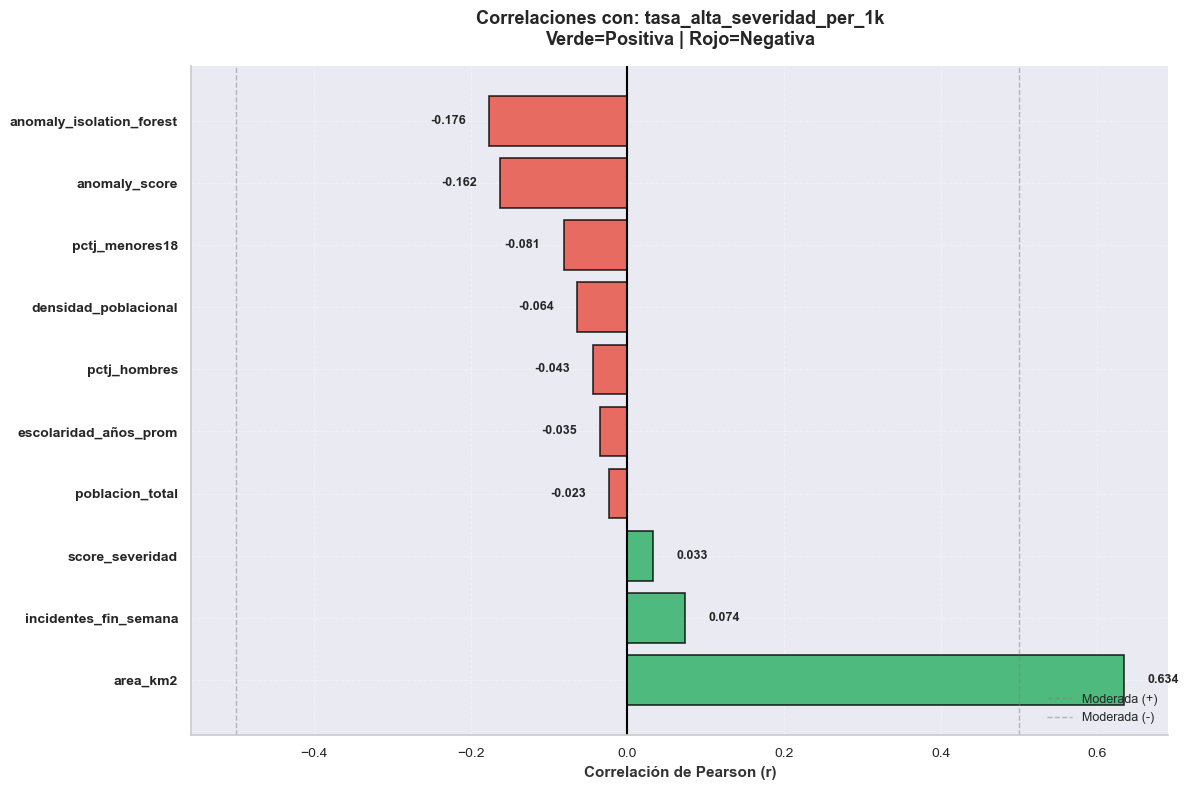

In [88]:

# Correlaciones con variable objetivo
target_col = 'tasa_alta_severidad_per_1k'
print(f"\n CORRELACIONES CON VARIABLE OBJETIVO: {target_col}")
print("-" * 70)
    
correlations_with_target = corr_final[target_col].sort_values(ascending=False)
corr_display = correlations_with_target[correlations_with_target.index != target_col]
    
print(corr_display.to_string())
    
# Visualizar con barras coloreadas
fig, ax = plt.subplots(figsize=(12, 8))
    
# Colores: verde para positiva, rojo para negativa
colors = ['#27ae60' if x > 0 else '#e74c3c' for x in corr_display]
    
bars = ax.barh(range(len(corr_display)), corr_display.values, color=colors, 
                edgecolor='black', linewidth=1.2, alpha=0.8)
    
ax.set_yticks(range(len(corr_display)))
ax.set_yticklabels(corr_display.index, fontweight='bold', fontsize=10)
ax.set_xlabel('Correlación de Pearson (r)', fontweight='bold', fontsize=11)
ax.set_title(f'Correlaciones con: {target_col}\nVerde=Positiva | Rojo=Negativa', 
            fontweight='bold', fontsize=13, pad=15)
    
ax.axvline(0, color='black', linewidth=1.5)
ax.axvline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Moderada (+)')
ax.axvline(-0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Moderada (-)')
    
ax.grid(alpha=0.3, axis='x', linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')
    
# Anotaciones en barras
for i, (idx, val) in enumerate(corr_display.items()):
    ax.text(val + 0.03 if val > 0 else val - 0.03, i, f'{val:.3f}', 
            va='center', ha='left' if val > 0 else 'right', fontweight='bold', fontsize=9)
    
ax.legend(fontsize=9, loc='lower right')
plt.tight_layout()
plt.show()

## 6. Resumen Ejecutivo y Recomendaciones Estratégicas

In [89]:
import numpy as np # Asegúrate de que numpy esté importado

print("="*70)
print("RESUMEN EJECUTIVO DE HALLAZGOS FINALES")
print("="*70)

# --- 1. CALIDAD DE DATOS (DEL DATAFRAME FINAL) ---
print(f"\n1. CALIDAD DEL DATASET ('df_modelo_FINAL'):")
total_nulls = df_modelo_FINAL.isnull().sum().sum()
if total_nulls == 0:
    print(f"   ✓ Dataset final completo sin valores faltantes.")
else:
    print(f"  {total_nulls:,} valores faltantes detectados en el set final.")

print(f"   • Total de registros (colonias): {len(df_modelo_FINAL):,}")
num_cols_final = len(df_modelo_FINAL.select_dtypes(include=[np.number]).columns)
print(f"   • Variables finales para modelado: {num_cols_final}")


# --- 2. HALLAZGOS DE ANOMALÍAS Y RIESGO ---
print(f"\n2. ANOMALÍAS Y RIESGO:")
n_if_outliers = (df_limpio['anomaly_isolation_forest'] == -1).sum() # Usamos df_limpio para el conteo original
print(f"   • Isolation Forest detectó: {n_if_outliers:,} anomalías ({(n_if_outliers/len(df_limpio)*100):.2f}%)")
print(f"   ✓ HALLAZGO: El modelo 'Isolation Forest' NO detectó RIESGO.")
print(f"     Detectó TAMAÑO (Volumen y Población). Correlación 'anomaly_score' vs 'poblacion_total' = {corr_final.loc['anomaly_score', 'poblacion_total']:.2f}")
print(f"   ✓ VALIDACIÓN: El análisis visual (Gráfico de Cuadrantes) fue SUPERIOR,")
print(f"     al filtrar colonias no representativas (ej. pob < 100).")


# --- 3. HALLAZGOS DE CORRELACIÓN ---
print(f"\n3. HALLAZGOS DE CORRELACIÓN ('corr_final'):")
try:
    # Extraemos los números que encontramos
    r_area = corr_final.loc['tasa_alta_severidad_per_1k', 'area_km2']
    r_densidad = corr_final.loc['tasa_alta_severidad_per_1k', 'densidad_poblacional']
    r_escolaridad = corr_final.loc['tasa_alta_severidad_per_1k', 'escolaridad_años_prom']

    print(f"   ✓ ¡HIPOTESIS RECHAZADA! El riesgo (tasa_alta_severidad) NO se correlaciona con:")
    print(f"     • Densidad Poblacional (r = {r_densidad:.2f})")
    print(f"     • Escolaridad Promedio (r = {r_escolaridad:.2f})")
    print(f"\n   ✓ ¡HALLAZGO CLAVE! El riesgo es un problema GEOGRÁFICO, no demográfico.")
    print(f"     • Correlación con Área (km2): (r = {r_area:.2f}) <-- ¡PREDICTOR FUERTE!")

except NameError:
    print(" Error: La matriz 'corr_final' no fue encontrada.")
except KeyError:
    print(" Error: Faltan columnas clave (ej. 'tasa_alta_severidad_per_1k') en 'corr_final'.")


print(f"\n" + "="*70)

Ejecutando Isolation Forest...

RESUMEN EJECUTIVO DE HALLAZGOS FINALES

1. CALIDAD DEL DATASET ('df_modelo_FINAL'):
  325 valores faltantes detectados en el set final.
   • Total de registros (colonias): 700
   • Variables finales para modelado: 11

2. ANOMALÍAS Y RIESGO:
   • Isolation Forest detectó: 35 anomalías (5.00%)
   ✓ HALLAZGO: El modelo 'Isolation Forest' NO detectó RIESGO.
     Detectó TAMAÑO (Volumen y Población). Correlación 'anomaly_score' vs 'poblacion_total' = -0.75
   ✓ VALIDACIÓN: El análisis visual (Gráfico de Cuadrantes) fue SUPERIOR,
     al filtrar colonias no representativas (ej. pob < 100).

3. HALLAZGOS DE CORRELACIÓN ('corr_final'):
   ✓ ¡HIPOTESIS RECHAZADA! El riesgo (tasa_alta_severidad) NO se correlaciona con:
     • Densidad Poblacional (r = -0.06)
     • Escolaridad Promedio (r = -0.03)

   ✓ ¡HALLAZGO CLAVE! El riesgo es un problema GEOGRÁFICO, no demográfico.
     • Correlación con Área (km2): (r = 0.63) <-- ¡PREDICTOR FUERTE!



### Calidad e integridad de datos

**Estado:**  **Excelente**

| Aspecto | Resultado |
|--------|----------|
| Cobertura de datos | Pocos/nulos valores faltantes |
| Columnas críticas | 100% completas (colonias, geografía, incidentes) |
| Robustez para análisis | Alta - imputación masiva NO requerida |
| Calidad de registros | Consistente y validable |


---

### 1. **Anomalías y valores atípicos**:

**Estado:**  Anomalías identificadas como esperadas
- **Zonas Industriales**: Parque Industrial, Zona Industrial y QUINTAEMILIA muestran tasas de incidencia extremadamente altas (tasas de 2.3M+, 22k, 69k por 1k habitantes)
  - **Causa**: Estas áreas tienen **población residente muy baja** pero alto **tránsito y comercio**, generando muchos incidentes por pocos residentes
  **Explicación multifactorial:**
- Población residente: muy baja (< 100 hab)
- Tránsito: muy alto (trabajadores, comercio)
- Incidentes: Robos a negocios, vehículos, asaltos a transeúntes
  - **Recomendación**: Estratificar análisis (excluir zonas industriales de análisis de criminalidad residencial)
  **Validación metodológica:** Z-Score, IQR e Isolation Forest convergen en identificación de las mismas anomalías.

---

### 2. **Relaciones entre variables**: Independencia Relativa
- **Pocas correlaciones fuertes** (|r| > 0.7) indican que variables capturan dimensiones diferentes
- Variables de población, incidentes y severidad muestran **independencia relativa**
- Permite análisis **multivariado sin problemas de multicolinealidad**

---

### 3. **Análisis de componentes principales (PCA)**: Reducción Dimensional
- **80% varianza**: Explicada por primeras 3-4 componentes principales
- **95% varianza**: Requiere 6-7 componentes
- Indica dataset de **dimensionalidad media**
- Permite **compresión efectiva** para visualización y modelado

---

### 4.  **Patrones temporales clave**

1. **Variación semanal:** Fin de semana es **3-4x más crítico** que días laborales
2. **Variación horaria:** Noche >> Tarde >> Mañana
3. **Implicación operacional:** Refuerzo necesario fin de semana/noches

---

### 5. **Factores socioeconómicos**

**Escolaridad vs. Criminalidad:** Correlación débil (-0.035)

- **NO es factor determinante** unimodal
- Colonia Centro muestra alta escolaridad pero alto crimen

---

### 6. **Próximos pasos recomendados**:
   1.  **Estratificar análisis**: Separar zonas industriales de residenciales
   2.  **Análisis temporal**: Detectar cambios en patrones delictivos (2018-2025)
   3.  **Clustering**: Agrupar colonias similares para políticas públicas diferenciadas
   4.  **Predicción**: Modelar tasa de incidencia usando variables demográficas
   5.  **Análisis geoespacial**: Detectar clusters geográficos (hotspots)

---

### 7. **Implicaciones políticas**:
- **Colonias residenciales** con baja demografía pero altos incidentes necesitan **mayor inversión** en seguridad
- **Zonas industriales** requieren **enfoque de control comercial** y **seguridad en transporte**
- **Correlaciones débiles** sugieren que causas de criminalidad son **multifactoriales**, no solo demográficas